<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Understanding COVID-19 with Pandas and NetworkX</h1>
<h1>Exploring Country Data</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 792f78317ecef2e33990957fccb9f5b18773bf8c

numpy     : 1.19.2
cartopy   : 0.18.0
json      : 2.0.9
pandas    : 1.1.3
matplotlib: 3.3.2
watermark : 2.1.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Johns Hopkins University Dataset

The JHU CoVID dataset has steadly become the unofficial standard dataset for the number of cases and deaths aroudn the world. You can download the continuously updated data from their [github repository](https://github.com/CSSEGISandData/COVID-19/):

In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

The repository contains 4 time series files:

- time_series_covid19_confirmed_global.csv
- time_series_covid19_deaths_global.csv
- time_series_covid19_confirmed_US.csv
- time_series_covid19_deaths_US.csv

correponding to confirmed cases and number of deaths globally by country and for the US by state.

These curated files result from an aggregation and standardization of several dozen national health authority reports and have become the go-to 

## Global data

We start by looking at the totals for confirmed cases and deaths around the world

In [5]:
confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv(url + 'time_series_covid19_deaths_global.csv')

The dataset include not only the number of total cases (or deaths) by country for eah day, but also state and province level information (in some cases), as well as Latitude and Longitude data:

In [6]:
confirmed.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  1/29/22  1/30/22  1/31/22  2/1/22  \
0        0        0        0        0  ...   161290   162111   162926  163555   
1        0        0        0        0  ...   254126   255741   258543  258543   
2        0        0        0        0  ...   249310   250774   252117  253520   
3        0        0        0        0  ...    35556    35556    35958   35958   
4        0        0        0        0  ...    98057    98076    98116   98226   

   2/2/22  2/3/22  2/4/22  2/5/22  2/6/22  2/7/22  
0  164190  164727  165358  165711  166191  166924  
1  261240  261240  263172  263172  264624  264875  
2  254885  255836  256806  257598  257976  258478  
3   36315   36470   36599   36599   36599   36808  
4   98267   98319   98340   98351   98364   98409  

[5 rows x 752 columns]

So we can easily see how the the disease has spread to the four corners of the world.

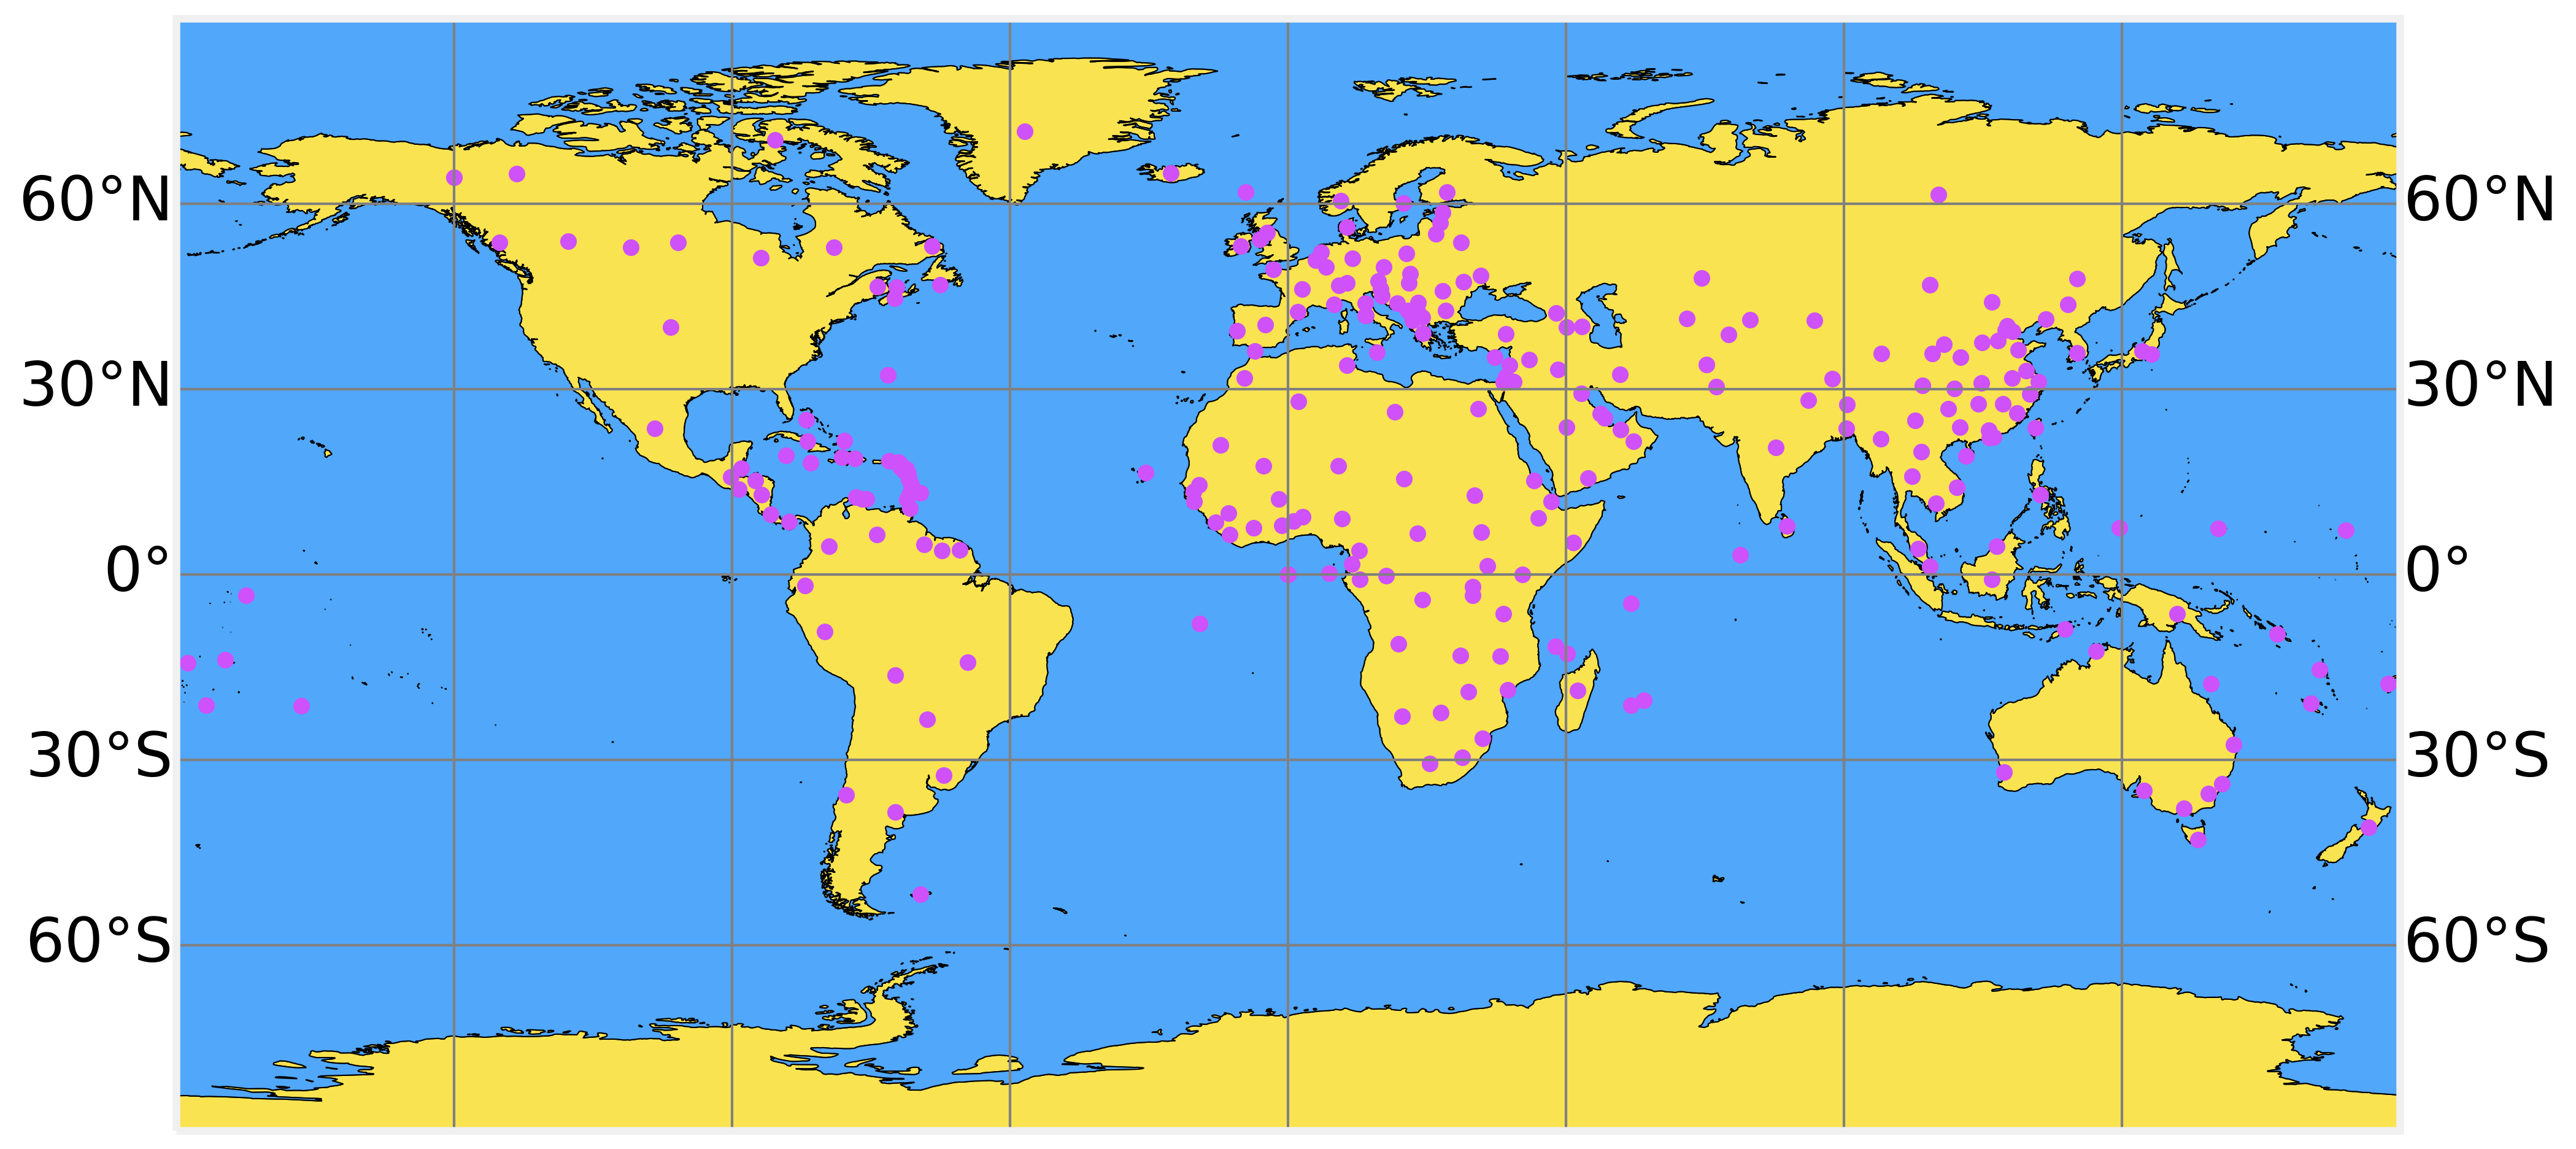

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=colors[4]))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=colors[0]))
ax.scatter(x=confirmed.Long, y=confirmed.Lat, zorder=2, color=colors[1])

ax.gridlines(draw_labels=True, 
             xlocs=np.arange(-180, 180.1, 45), 
             ylocs=np.arange(-90, 90.1, 30),
             color='gray')

plt.tight_layout()

We can obtain the country totals by aggregating over all the regions. The easiest way to do this is to remove the extraneous columns and sum by column

In [8]:
del_columns = [
 'Province/State',
 'Lat',
 'Long',
]

For convenience, we also transpose the data so that each row corresponds to a specific date. This will make it easier to select specific countries for plotting

In [9]:
confirmed_timeline = confirmed.drop(columns=del_columns).groupby('Country/Region').sum().T
deaths_timeline = deaths.drop(columns=del_columns).groupby('Country/Region').sum().T

In order to take full advantage of Pandas time series support we convert the dates to datetime format:

In [10]:
confirmed_timeline.index = pd.to_datetime(confirmed_timeline.index)
deaths_timeline.index = pd.to_datetime(deaths_timeline.index)

In total we have information about 188 countries, and we can easily see how quickly the virus has spread around the world

Text(0, 0.5, 'Number of countries and Regions')

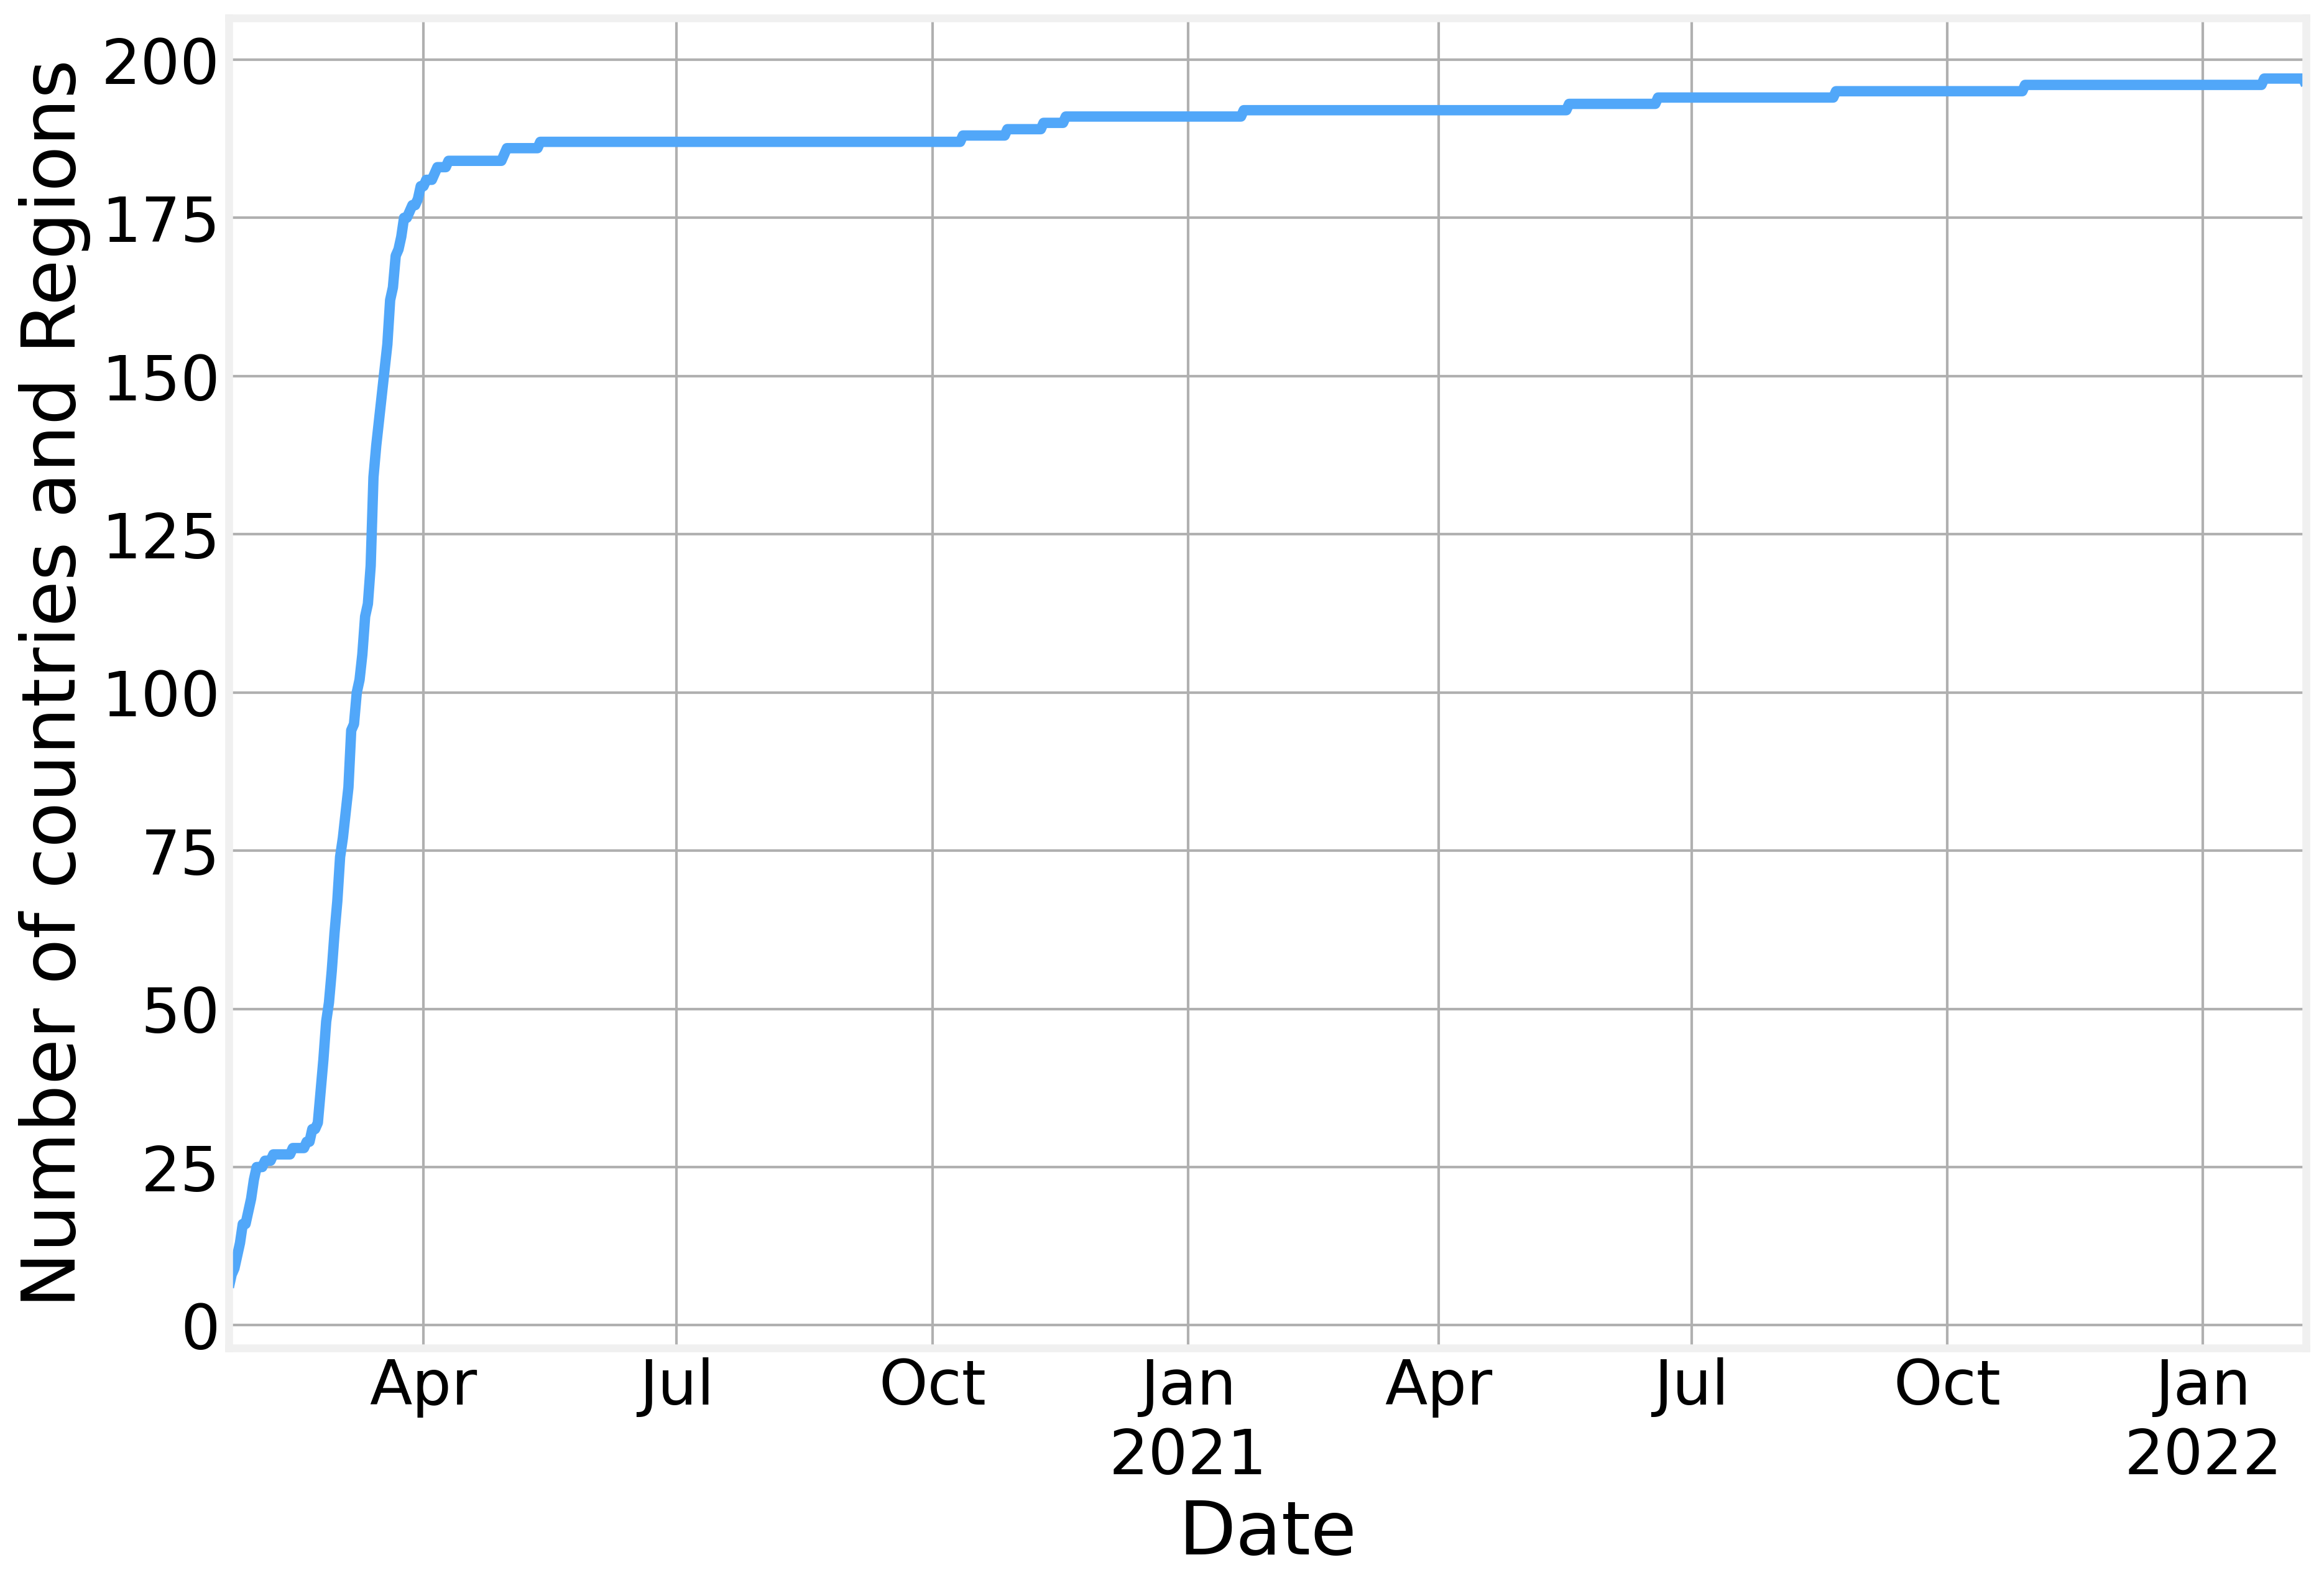

In [11]:
ax = (confirmed_timeline>0).sum(axis=1).plot()
ax.set_xlabel('Date')
ax.set_ylabel('Number of countries and Regions')

Where we identify 4 distinct phases:

(18283.0, 18383.0)

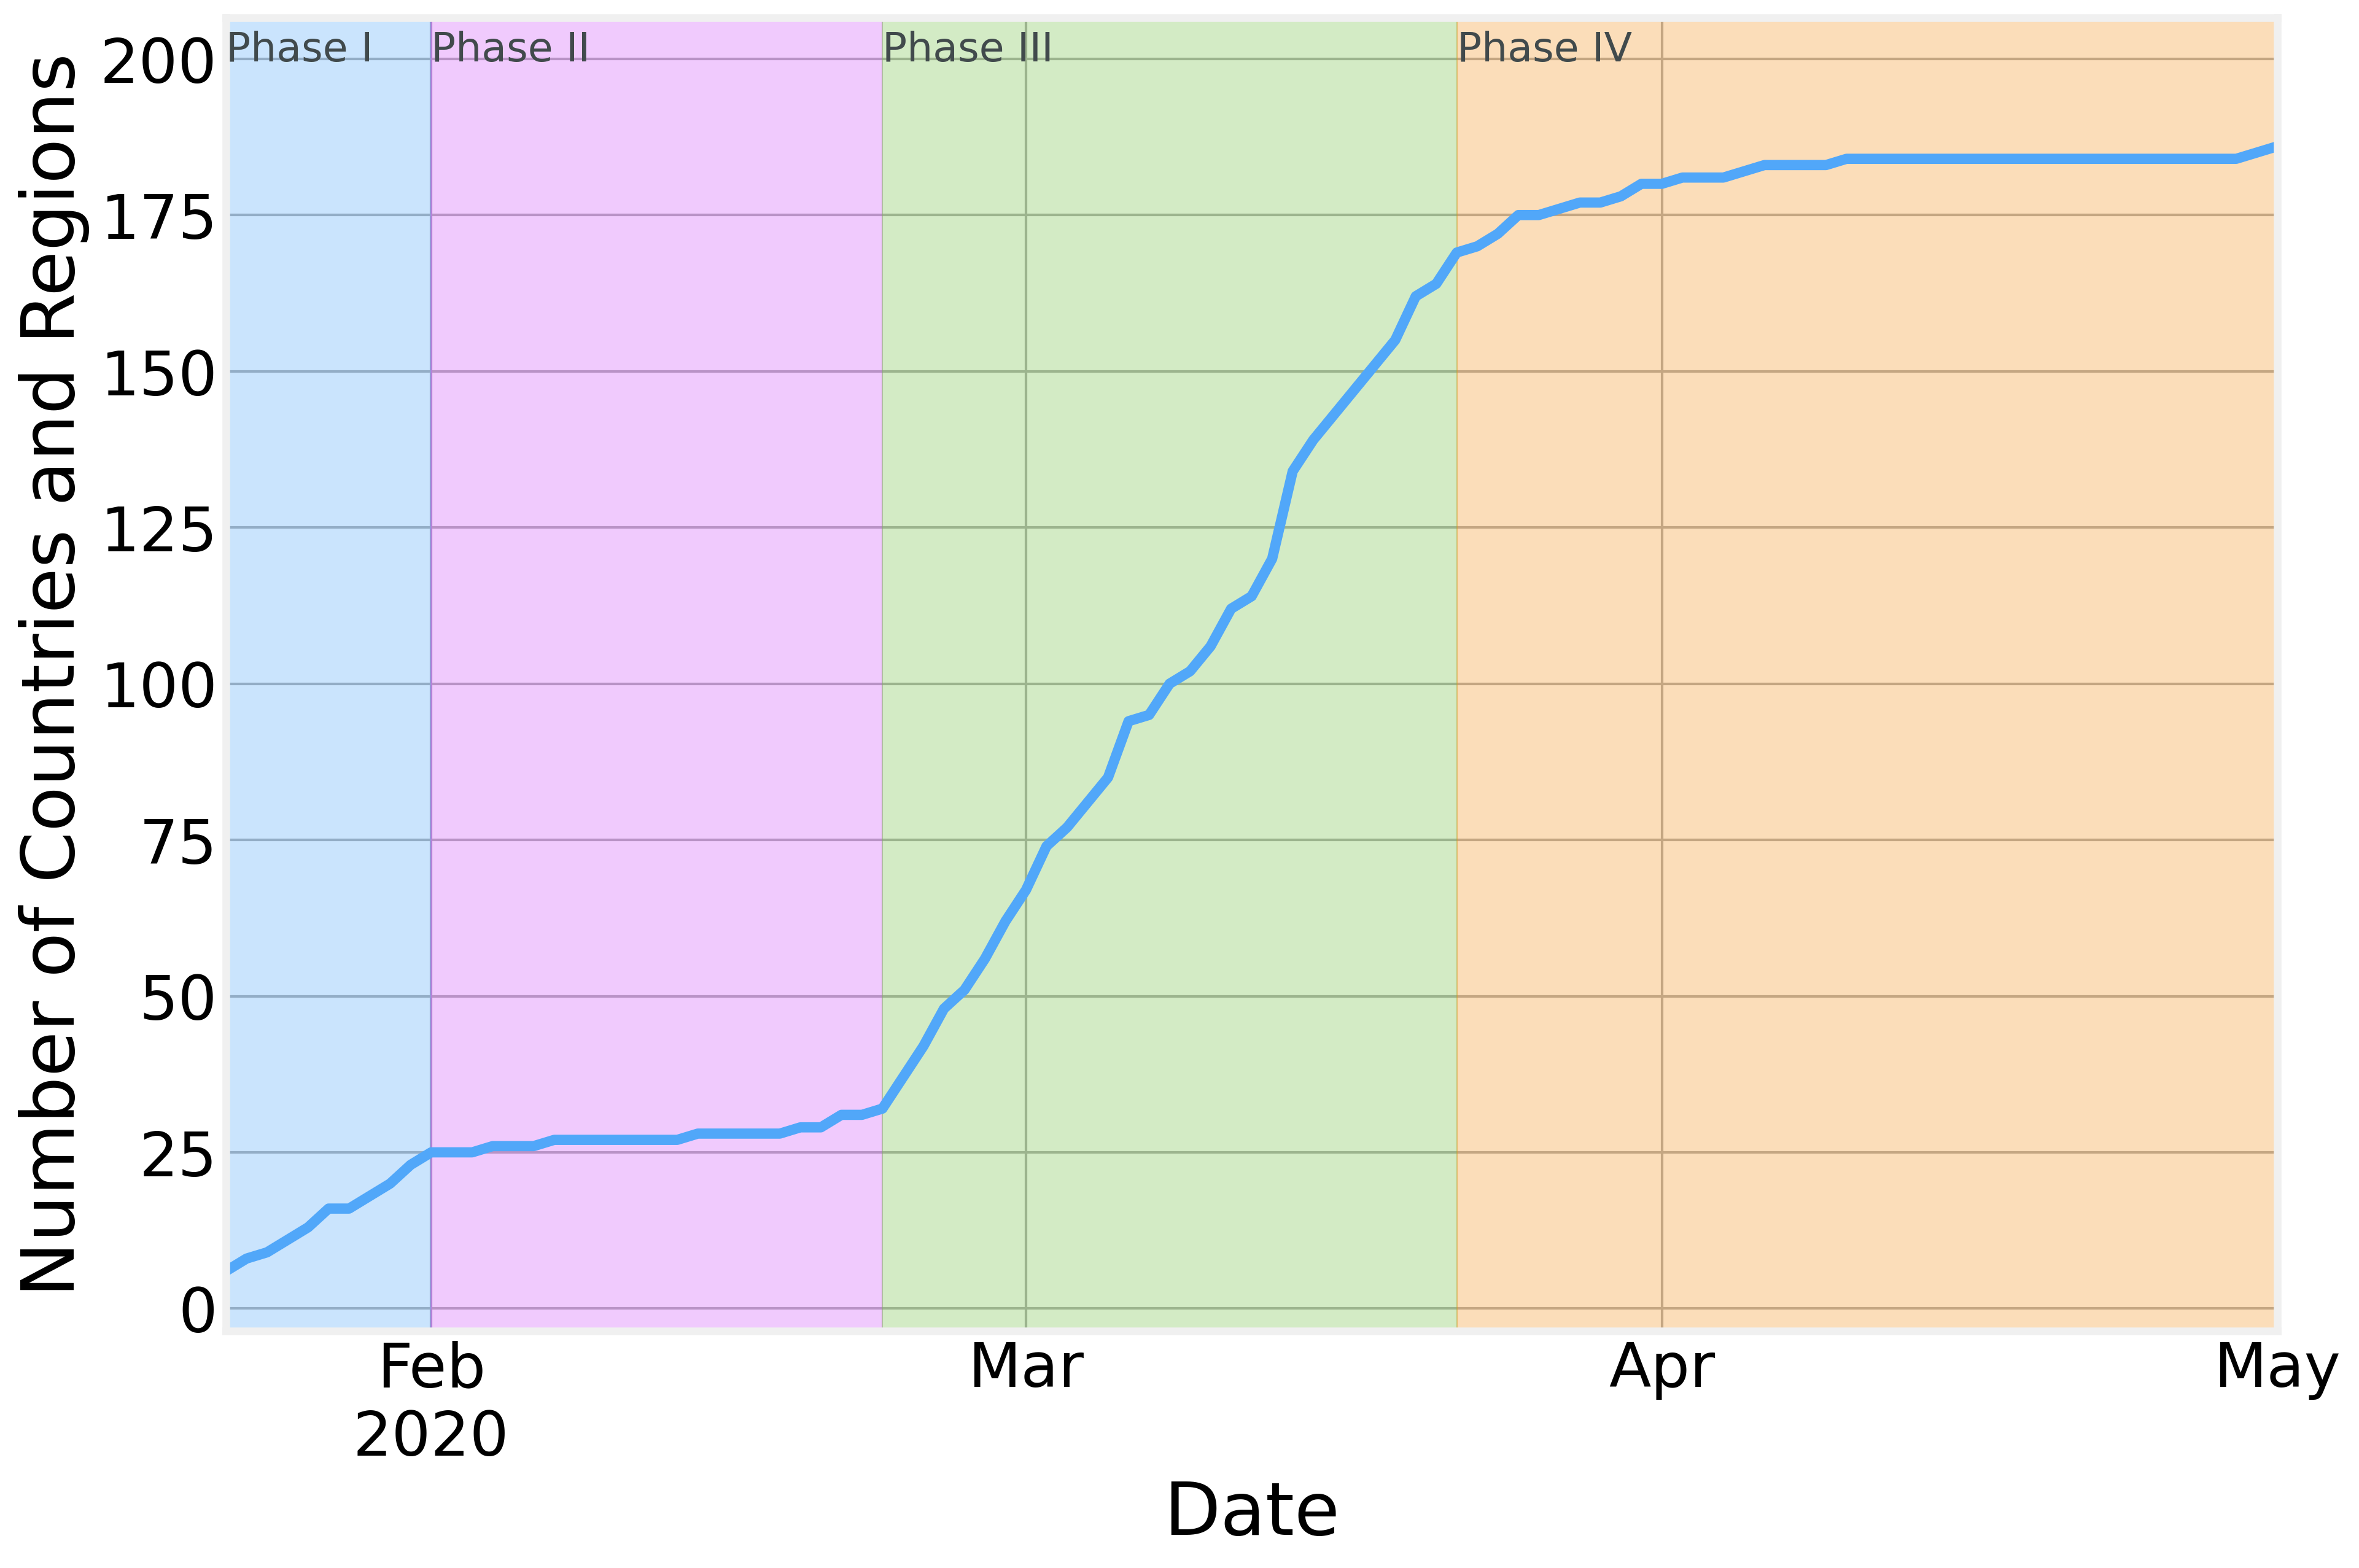

In [12]:
ax = (confirmed_timeline>0).sum(axis=1).plot()

ax.axvspan(xmin=confirmed_timeline.index.min(), xmax='2020-02-01', color=colors[0], alpha=.3)
ax.axvspan(xmin='2020-02-01', xmax='2020-02-23',  color=colors[1], alpha=.3)
ax.axvspan(xmin='2020-02-23', xmax='2020-03-22',  color=colors[2], alpha=.3)
ax.axvspan(xmin='2020-03-22', xmax=confirmed_timeline.index.max(), color=colors[3], alpha=.3)

ymin, ymax = ax.get_ylim()
ax.text(x=confirmed_timeline.index.min(), y=ymax-2, s='Phase I', fontsize=16, va='top', color='#414A4C')
ax.text(x='2020-02-01', y=ymax-2, s='Phase II', fontsize=16, va='top', color='#414A4C')
ax.text(x='2020-02-23', y=ymax-2, s='Phase III', fontsize=16, va='top', color='#414A4C')
ax.text(x='2020-03-22', y=ymax-2, s='Phase IV', fontsize=16, va='top', color='#414A4C')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Countries and Regions')
ax.set_xlim(confirmed_timeline.index.min(), '2020-05-01')

We can easily identify the date when the first case was reported. Unfortunately, the dataset starts on Jan 22 so that's the earliest date we are able to obtain. Fortunately, there are only 6 countries where the first case occured before then

In [13]:
confirmed_timeline[confirmed_timeline>0].idxmin()

Country/Region
Afghanistan            2020-02-24
Albania                2020-03-09
Algeria                2020-02-25
Andorra                2020-03-02
Angola                 2020-03-20
                          ...    
West Bank and Gaza     2020-03-05
Winter Olympics 2022   2022-01-23
Yemen                  2020-04-10
Zambia                 2020-03-18
Zimbabwe               2020-03-20
Length: 197, dtype: datetime64[ns]

In [14]:
start_dates = pd.DataFrame(confirmed_timeline[confirmed_timeline>0].idxmin().sort_values())
start_dates.columns = ['First Case']

The countries in this first phase were located mostly in Asia or had strong connections with China

In [15]:
start_dates[start_dates<='2020-02-01'].dropna()

First Case
Country/Region                 
Japan                2020-01-22
Korea, South         2020-01-22
US                   2020-01-22
Thailand             2020-01-22
Taiwan*              2020-01-22
China                2020-01-22
Vietnam              2020-01-23
Singapore            2020-01-23
France               2020-01-24
Malaysia             2020-01-25
Nepal                2020-01-25
Canada               2020-01-26
Australia            2020-01-26
Sri Lanka            2020-01-27
Germany              2020-01-27
Cambodia             2020-01-27
Finland              2020-01-29
United Arab Emirates 2020-01-29
Philippines          2020-01-30
India                2020-01-30
Italy                2020-01-31
Russia               2020-01-31
United Kingdom       2020-01-31
Sweden               2020-02-01
Spain                2020-02-01

On the second stage, the disease seemed to be relatively contained within just a few countries and with limited spread to new locations. In these 3 weeks, it spread to just 5 new countries (plus the Diamond Princess cruise ship)

In [16]:
start_dates[(start_dates>'2020-02-01') & (start_dates<='2020-02-23')].dropna()

First Case
Country/Region             
Belgium          2020-02-04
Diamond Princess 2020-02-07
Egypt            2020-02-14
Iran             2020-02-19
Lebanon          2020-02-21
Israel           2020-02-21
Chile            2020-02-23

The third stage was when it trully spread worldwide, we 4-5 new countries reporting cases each day

In [17]:
start_dates[(start_dates>'2020-02-23') & (start_dates<= '2020-03-22')]\
            .dropna().reset_index().groupby('First Case').count().sort_index()

Country/Region
First Case                
2020-02-24               5
2020-02-25               5
2020-02-26               6
2020-02-27               3
2020-02-28               5
2020-02-29               6
2020-03-01               5
2020-03-02               7
2020-03-03               3
2020-03-04               4
2020-03-05               4
2020-03-06               9
2020-03-07               1
2020-03-08               5
2020-03-09               2
2020-03-10               4
2020-03-11               6
2020-03-12               2
2020-03-13               6
2020-03-14              14
2020-03-15               5
2020-03-16               4
2020-03-17               3
2020-03-18               4
2020-03-19               4
2020-03-20               7
2020-03-21               3
2020-03-22               5

Finally, Phase IV was when the final smaller and more isolated countries became infected as well

In [18]:
start_dates[(start_dates>'2020-03-22')].dropna()

First Case
Country/Region                  
Belize                2020-03-23
Libya                 2020-03-24
Laos                  2020-03-24
Guinea-Bissau         2020-03-25
Saint Kitts and Nevis 2020-03-25
Mali                  2020-03-25
Burma                 2020-03-27
MS Zaandam            2020-03-28
Botswana              2020-03-30
Burundi               2020-03-31
Sierra Leone          2020-03-31
Malawi                2020-04-02
South Sudan           2020-04-05
Sao Tome and Principe 2020-04-06
Yemen                 2020-04-10
Comoros               2020-04-30
Tajikistan            2020-05-01
Lesotho               2020-05-13
Solomon Islands       2020-10-12
Marshall Islands      2020-11-05
Vanuatu               2020-11-10
Samoa                 2020-11-18
Micronesia            2021-01-21
Kiribati              2021-05-18
Summer Olympics 2020  2021-06-19
Palau                 2021-08-22
Tonga                 2021-10-29
Winter Olympics 2022  2022-01-23

# Global Number of cases

In [19]:
countries = pd.read_csv('data/countries.csv', index_col=1)

In [20]:
world = confirmed_timeline.T.join(countries).groupby('Continent').sum().T

In [21]:
world.index = pd.to_datetime(world.index)

In [22]:
world = world.diff(1).rolling(7).mean()

Clean up the data

In [23]:
world[world < 0] = 0

Text(0.5, 0, 'Date')

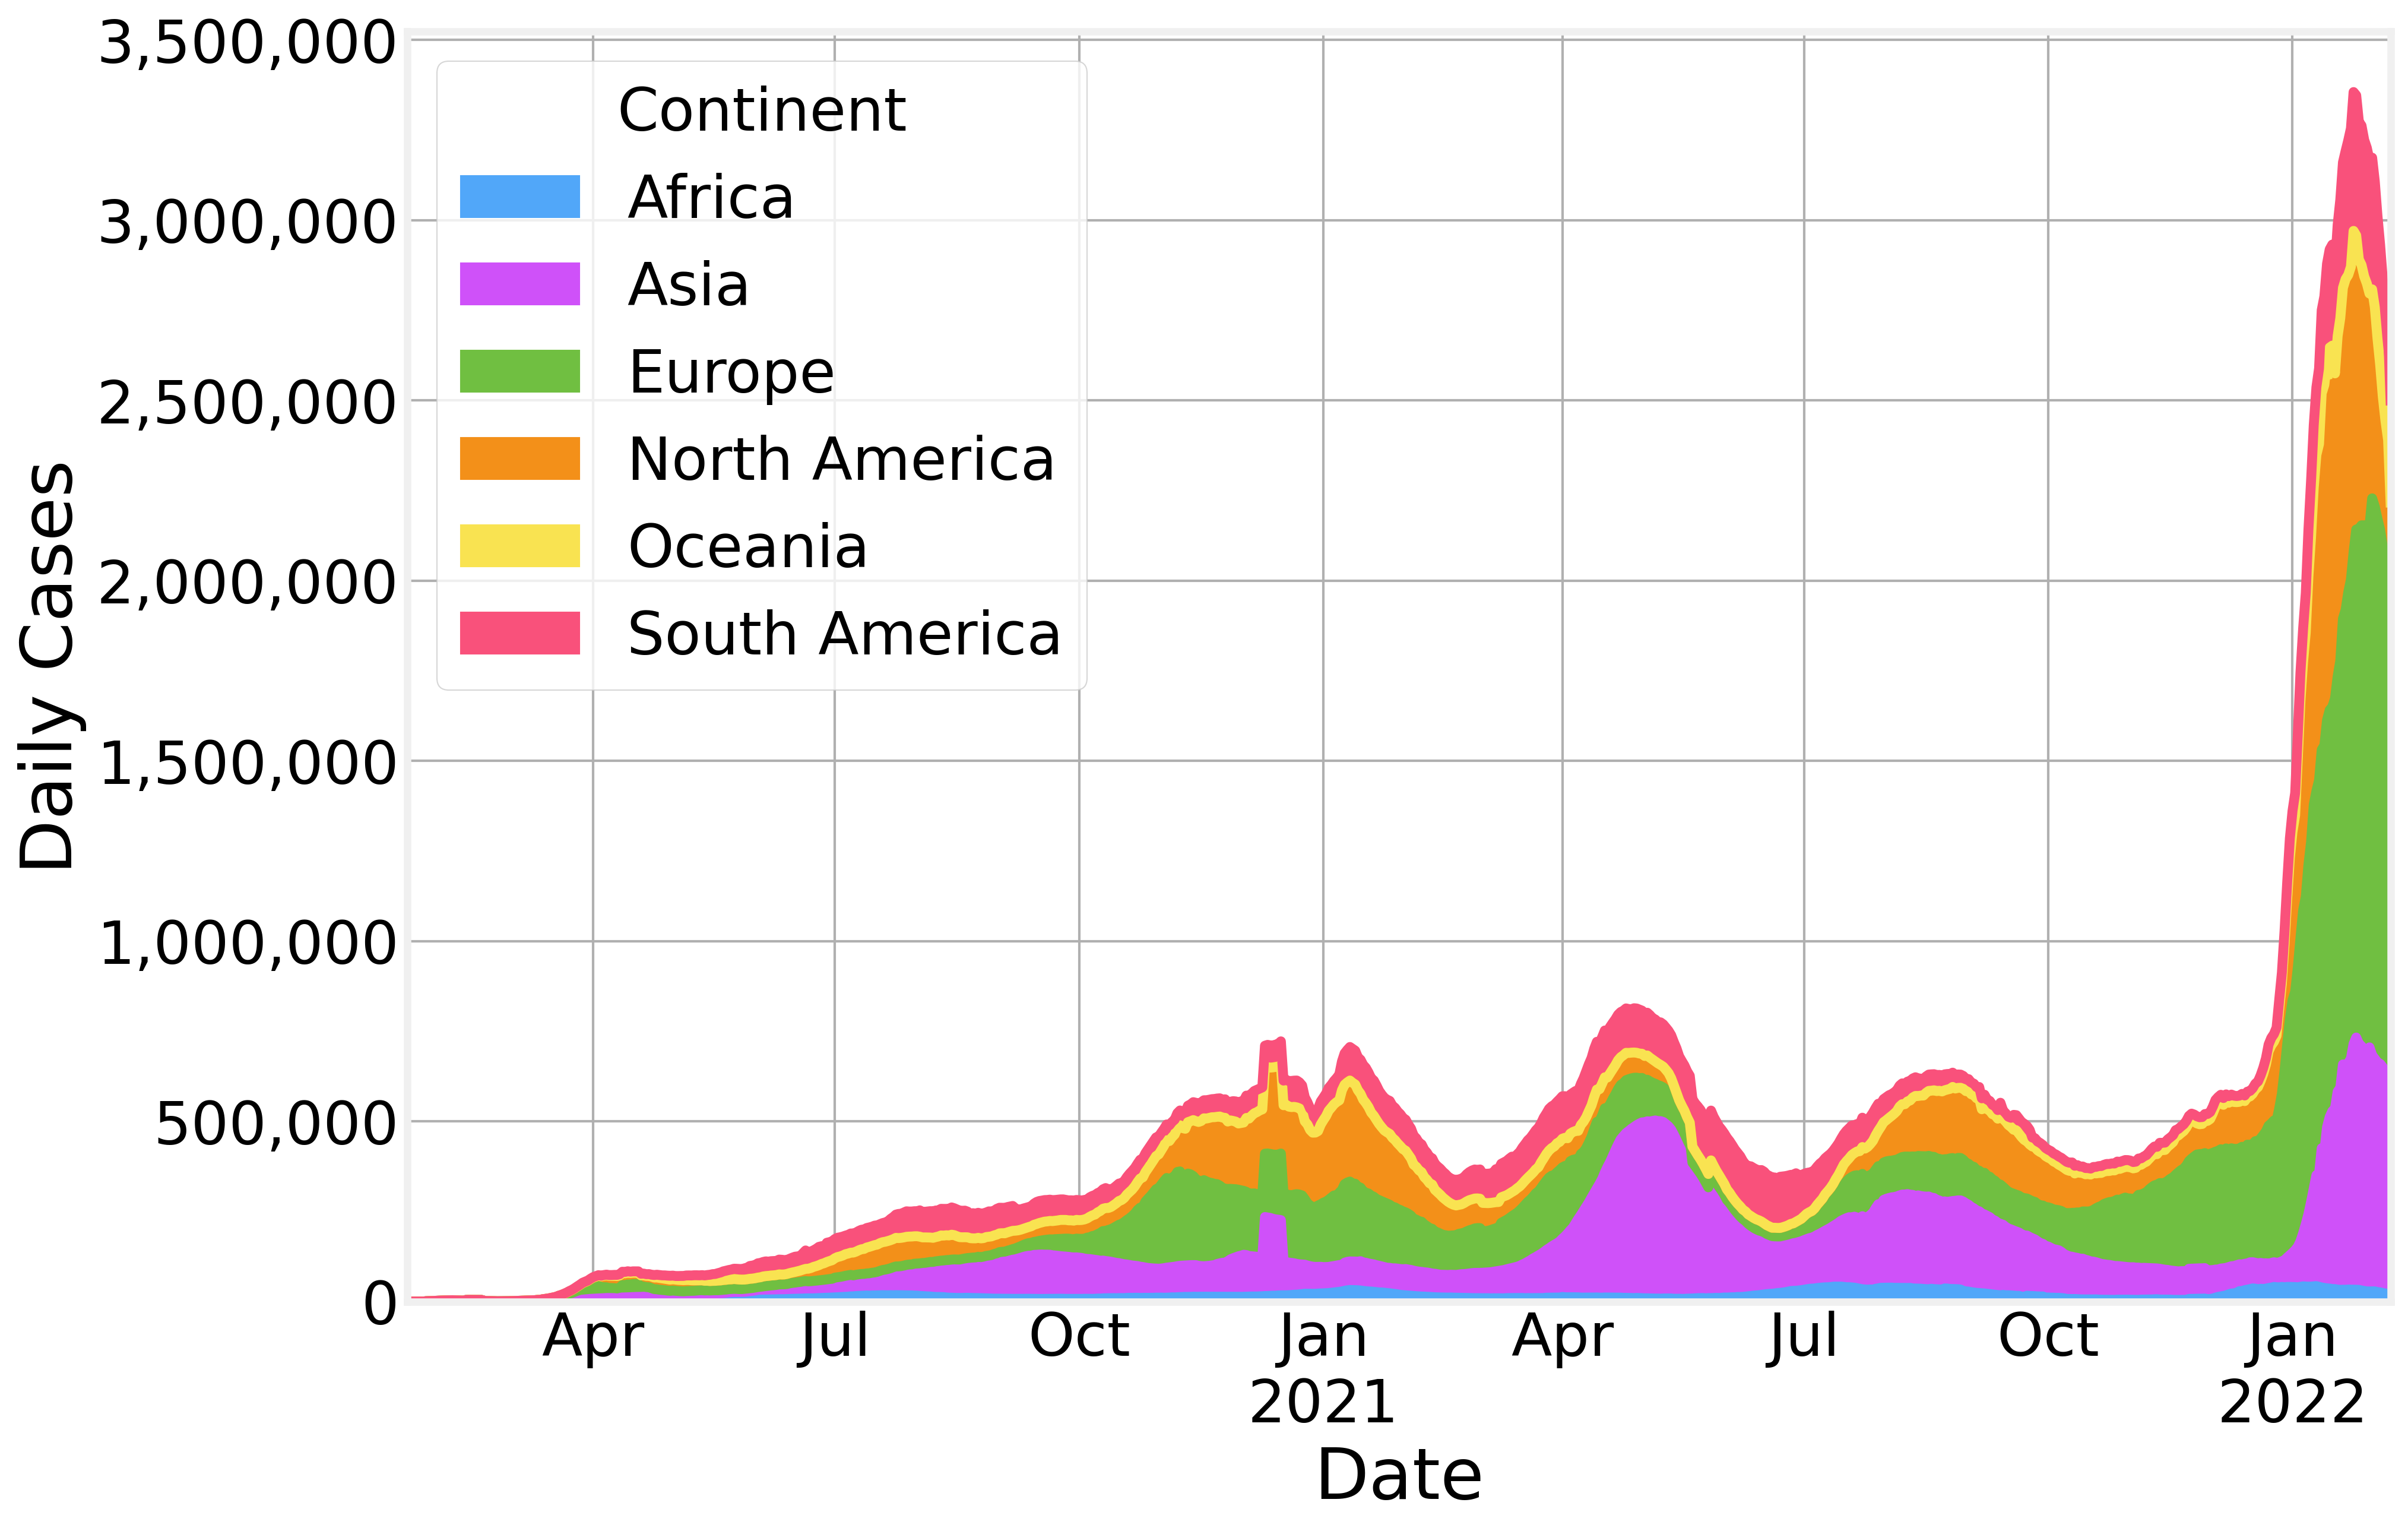

In [24]:
ax = world.plot.area()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Daily Cases')
ax.set_xlabel('Date')

## Country level analysis

Now we can select specific countries easily. For example, to get a quick plot the totals for the US we must simply do:

<AxesSubplot:>

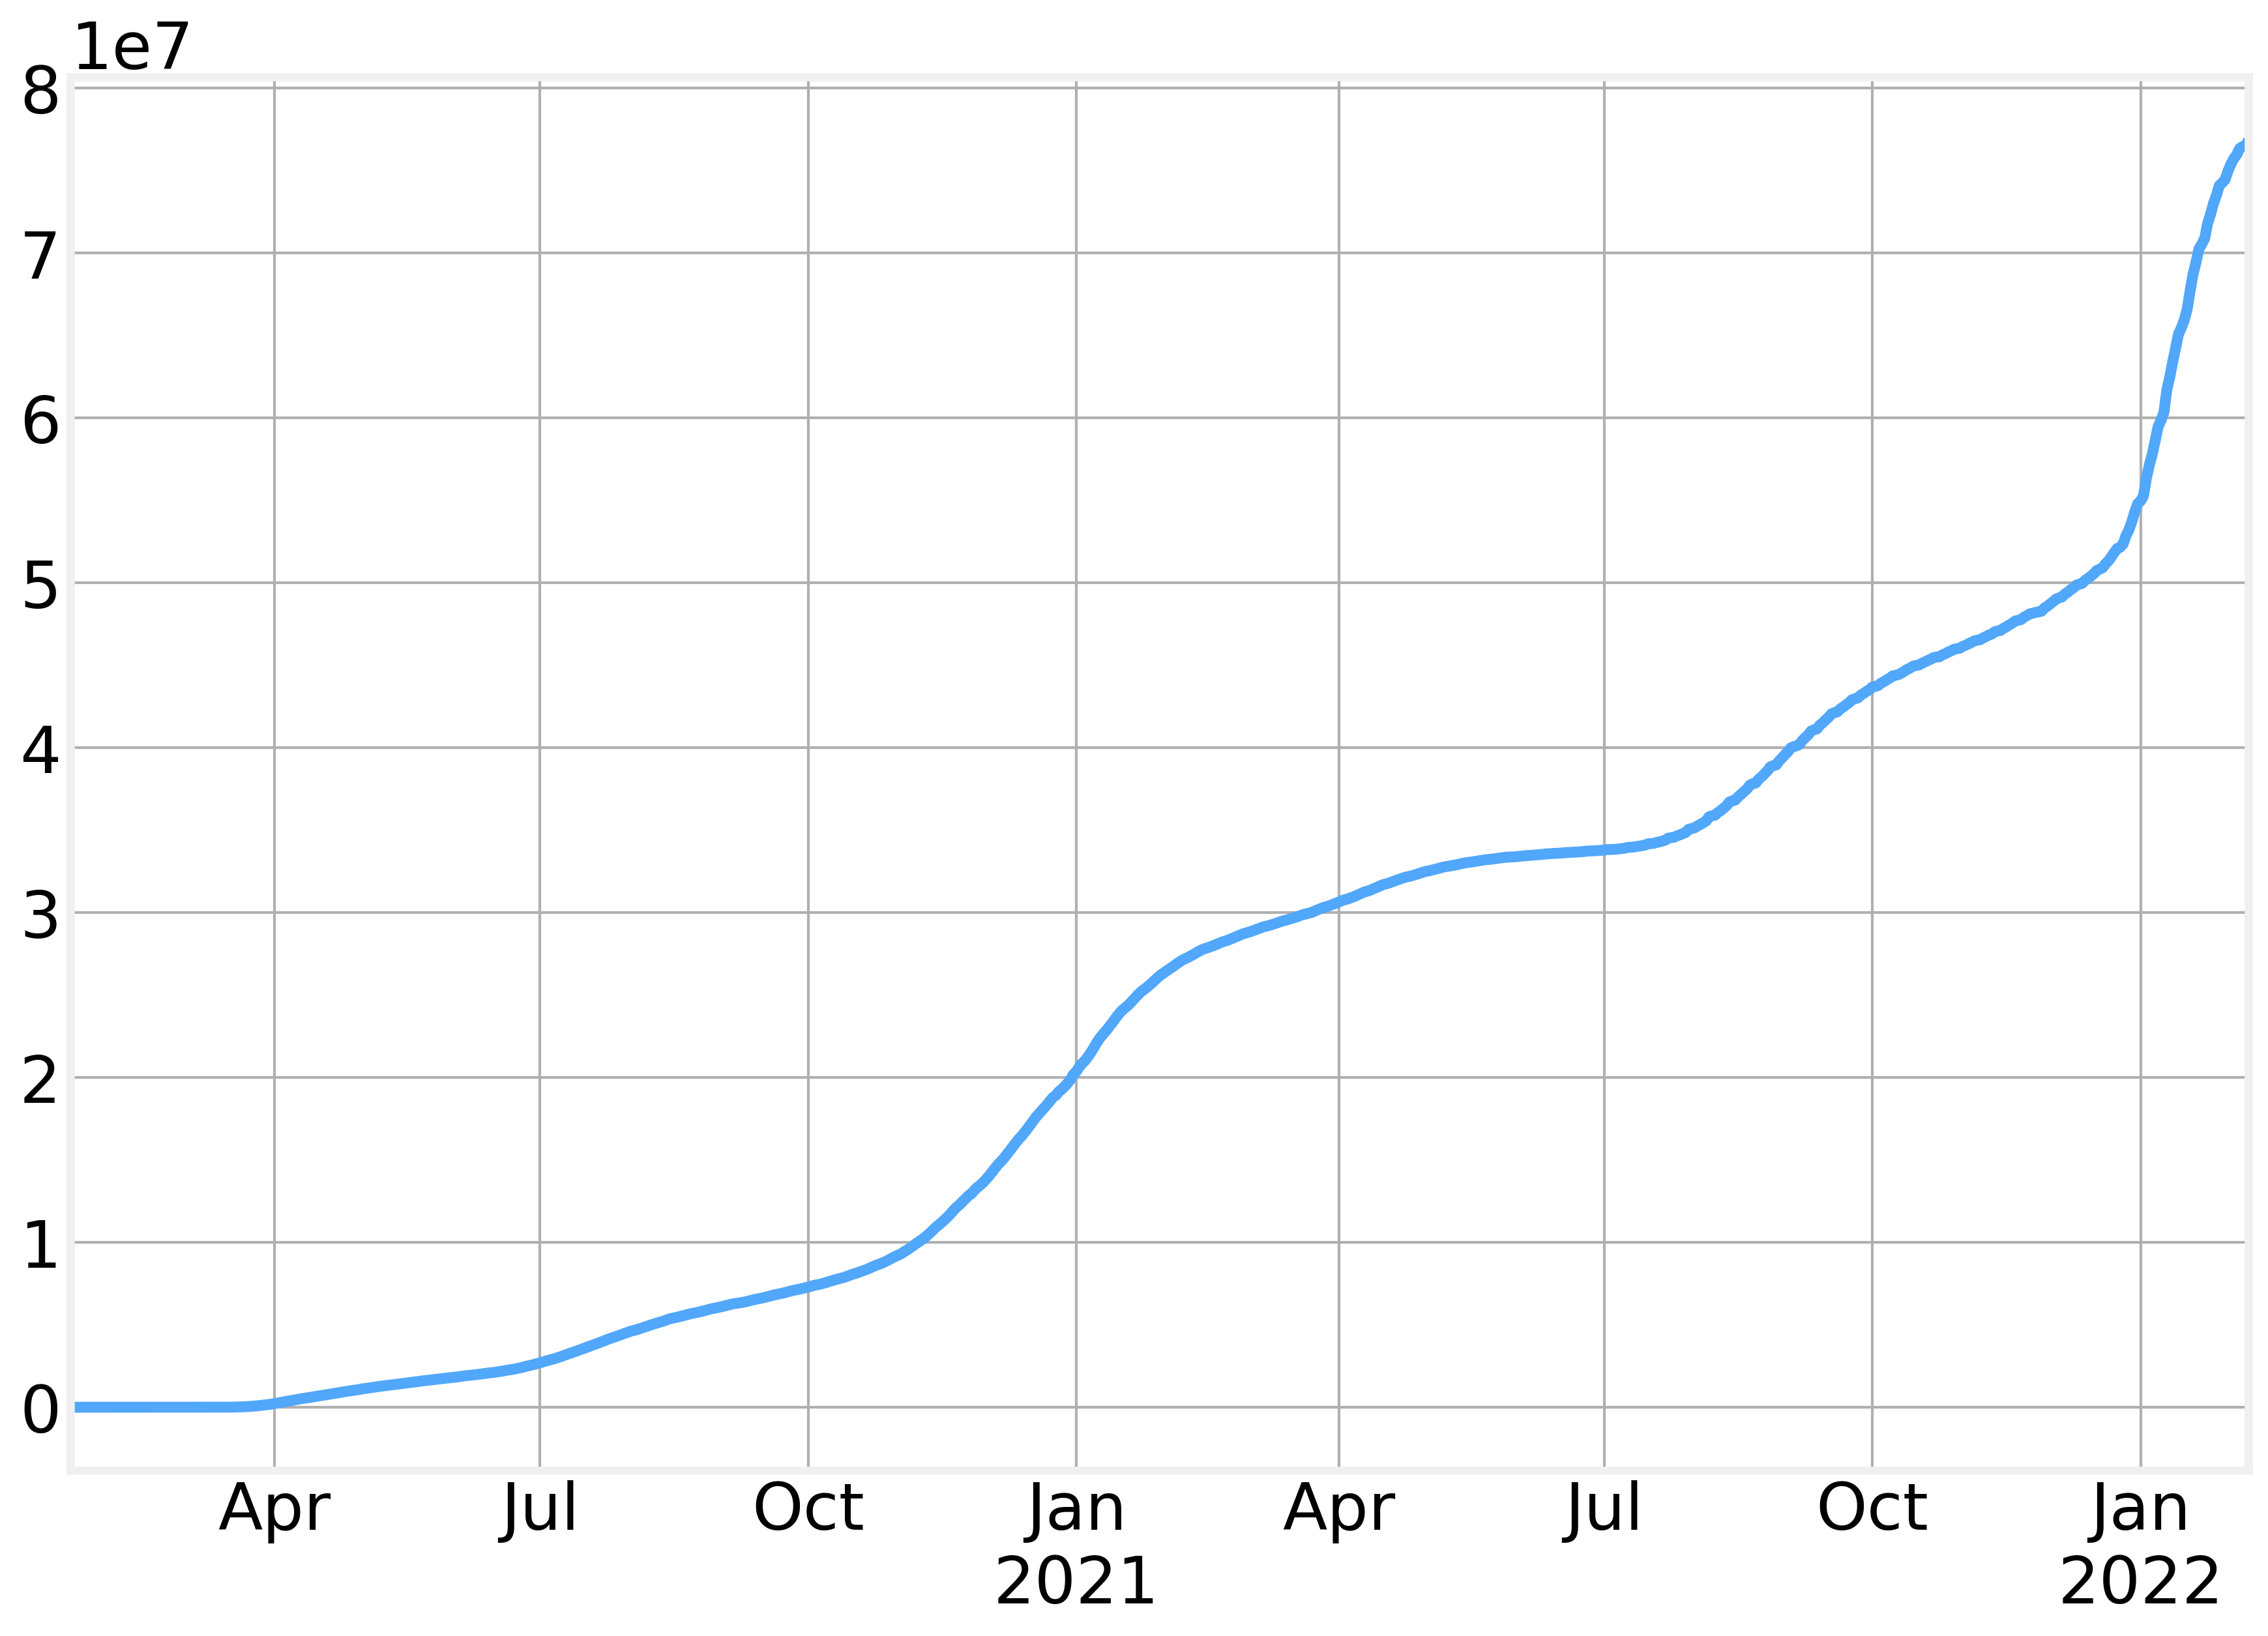

In [25]:
confirmed_timeline['US'].plot()

### United States

As we can see, the data includes only the comulative number of cases. We can obtain the daily numbers by taking the day to day differences

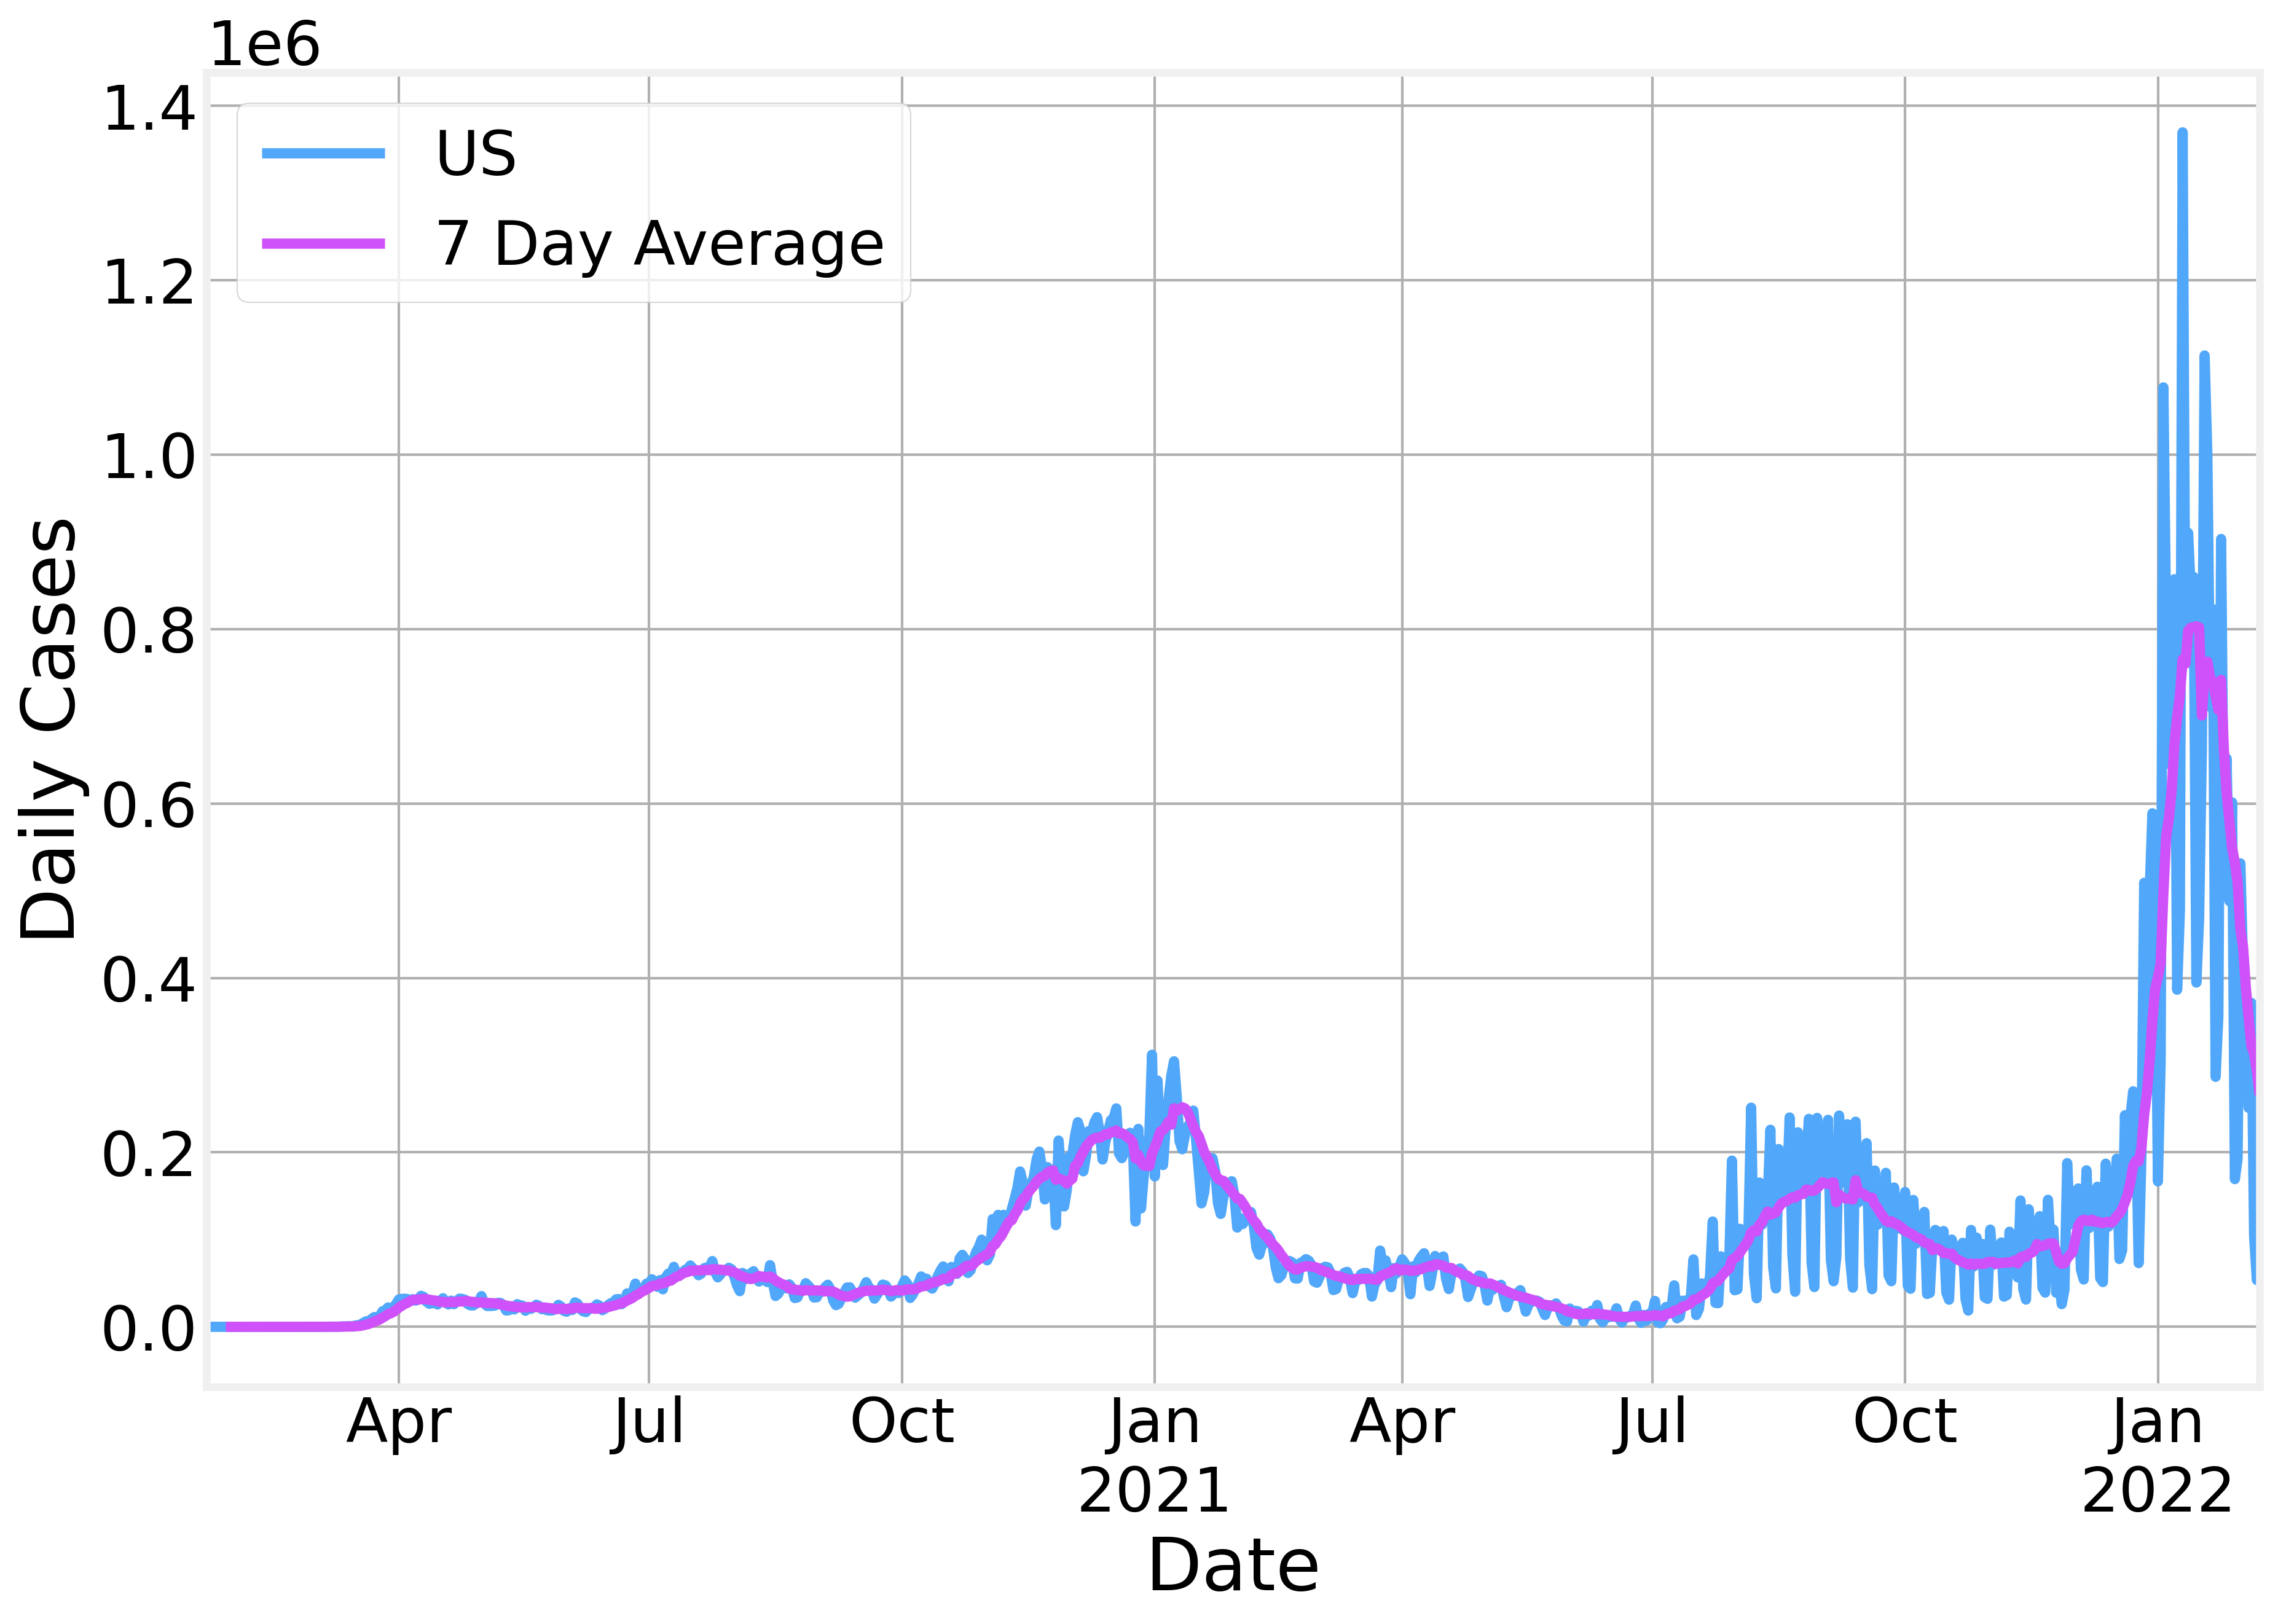

In [26]:
ax = confirmed_timeline['US'].diff(1).plot()
confirmed_timeline['US'].diff(1).rolling(7).mean().plot(ax=ax, label='7 Day Average')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Cases')
ax.legend()

This data is naturally noisy due to issues in coordinating the values reported by the various regions and institutions. We can obtain a cleaner picture by taking a rolling 7 day average:

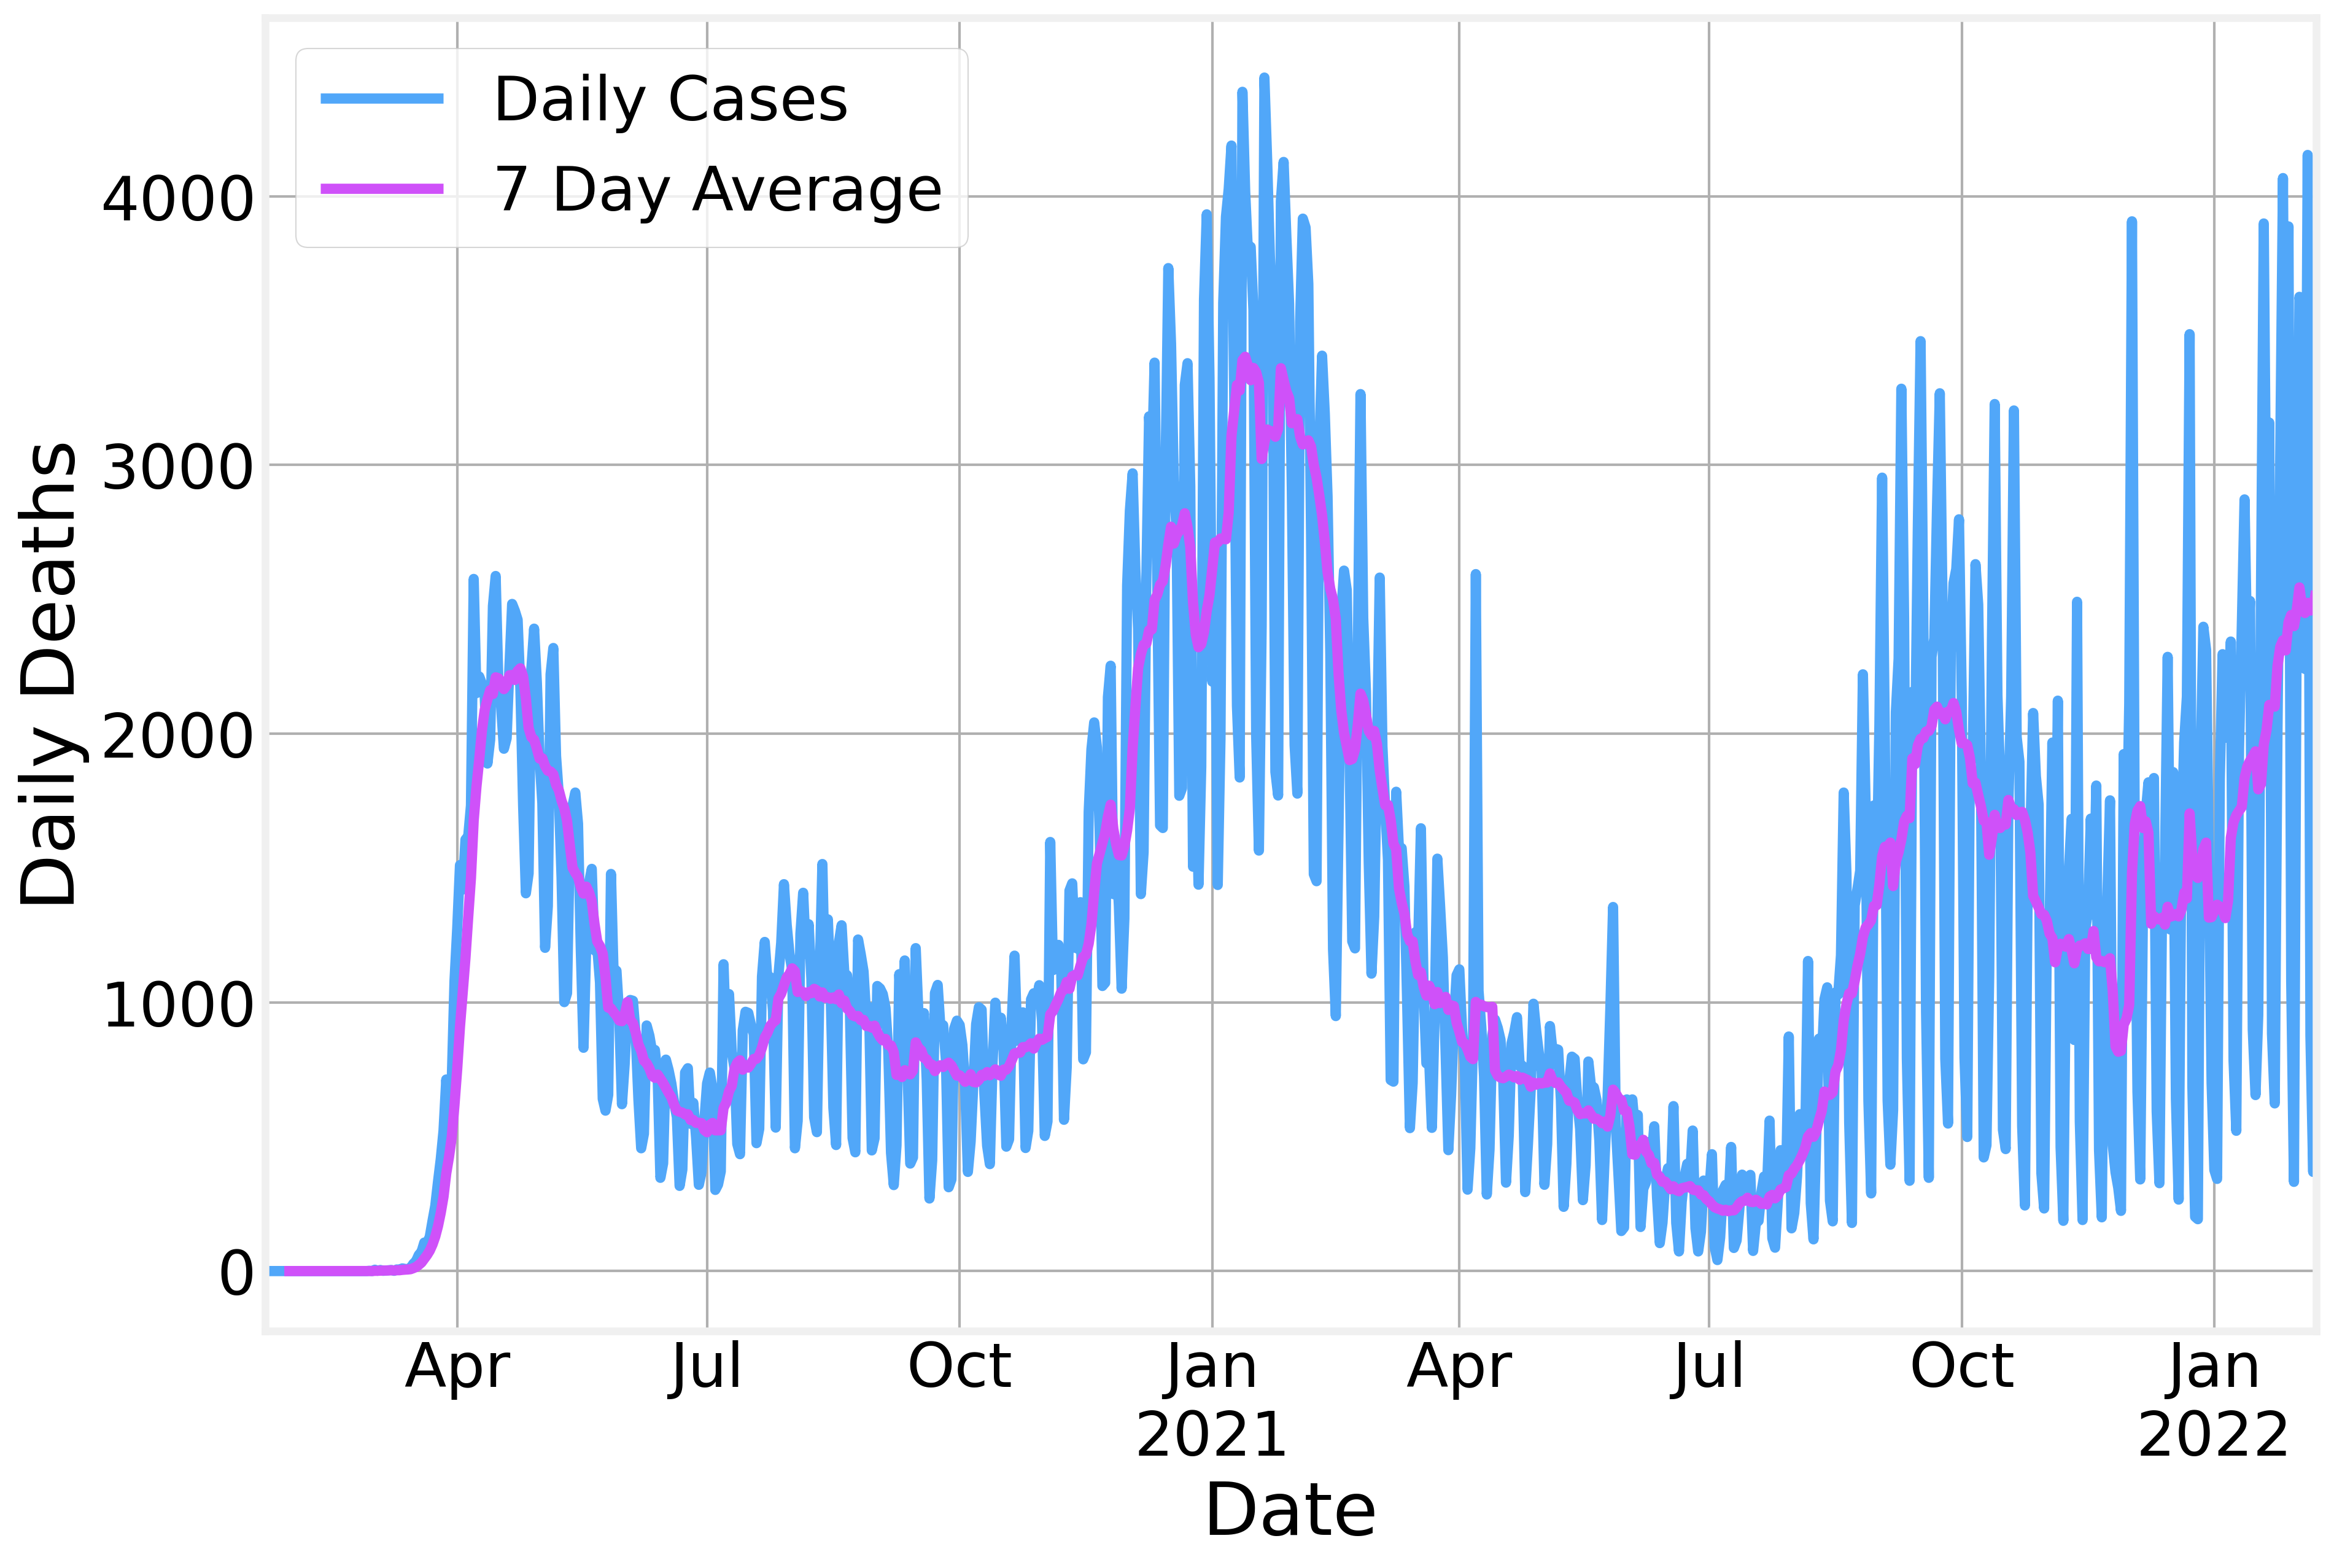

In [27]:
ax = deaths_timeline['US'].diff(1).plot(label='Daily Cases')
deaths_timeline['US'].diff(1).rolling(7).mean().plot(ax=ax, label='7 Day Average')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')
ax.legend()

In [28]:
confirmed_US = pd.read_csv(url + 'time_series_covid19_confirmed_US.csv')

As in the case of the country level data, there are several other columns that we don't need

In [29]:
confirmed_US.head()

UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   
3  84001007   US  USA    840  1007.0     Bibb        Alabama             US   
4  84001009   US  USA    840  1009.0   Blount        Alabama             US   

         Lat      Long_  ... 1/29/22  1/30/22  1/31/22  2/1/22  2/2/22  \
0  32.539527 -86.644082  ...   14291    14498    14742   14782   14826   
1  30.727750 -87.722071  ...   52255    52459    52649   52881   53083   
2  31.868263 -85.387129  ...    5224     5241     5263    5276    5297   
3  32.996421 -87.125115  ...    6049     6088     6107    6130    6158   
4  33.982109 -86.567906  ...   13930    13981    14056   14096   14158   

   2/3/22  2/4/22  2/5/22  2/6/22  2/7/22  
0   14826   14970   14999   14999   15046  
1   53083   53559   53637   53637   53768  
2    5297    5338    5346    5346    5356  
3    6158    6204    6208    6208    6224  
4   14158   14299   14329   14329   14366  

[5 rows x 759 columns]

We remove the extraneous columns

In [30]:
del_columns = [
 'UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
]

And aggregate at the state level.

In [31]:
confirmed_US.drop(columns=del_columns, inplace=True)
confirmed_US.drop(columns='Admin2', inplace=True)
confirmed_US = confirmed_US.groupby('Province_State').sum().T
confirmed_US.index = pd.to_datetime(confirmed_US.index)

### Country Overview

A simply way of getting a quick overview of the situation in all the states is to include some degree of geographical information to plot the time series of all the states side by side. We opt to use a block map where each state is represented by an equal size square block where we can plot the time series.

We load the coordinates of each state from a csv file

In [32]:
states = pd.read_csv('data/states.csv', index_col=0)

And create a convenient dictionary to convert from state abbreviations to full state names

In [33]:
state_dict = dict(states.reset_index()[['index', 'name']].values)

And now we plot the time series for each state, normalized by the peak value, within each block. Further, we color the block based on the current value of the number of cases:

- Green, below 25% of the peak value
- Orange, between 25-75% of the peak value
- Red, above 75% of the peak value

as an indication of how well each state is doing.

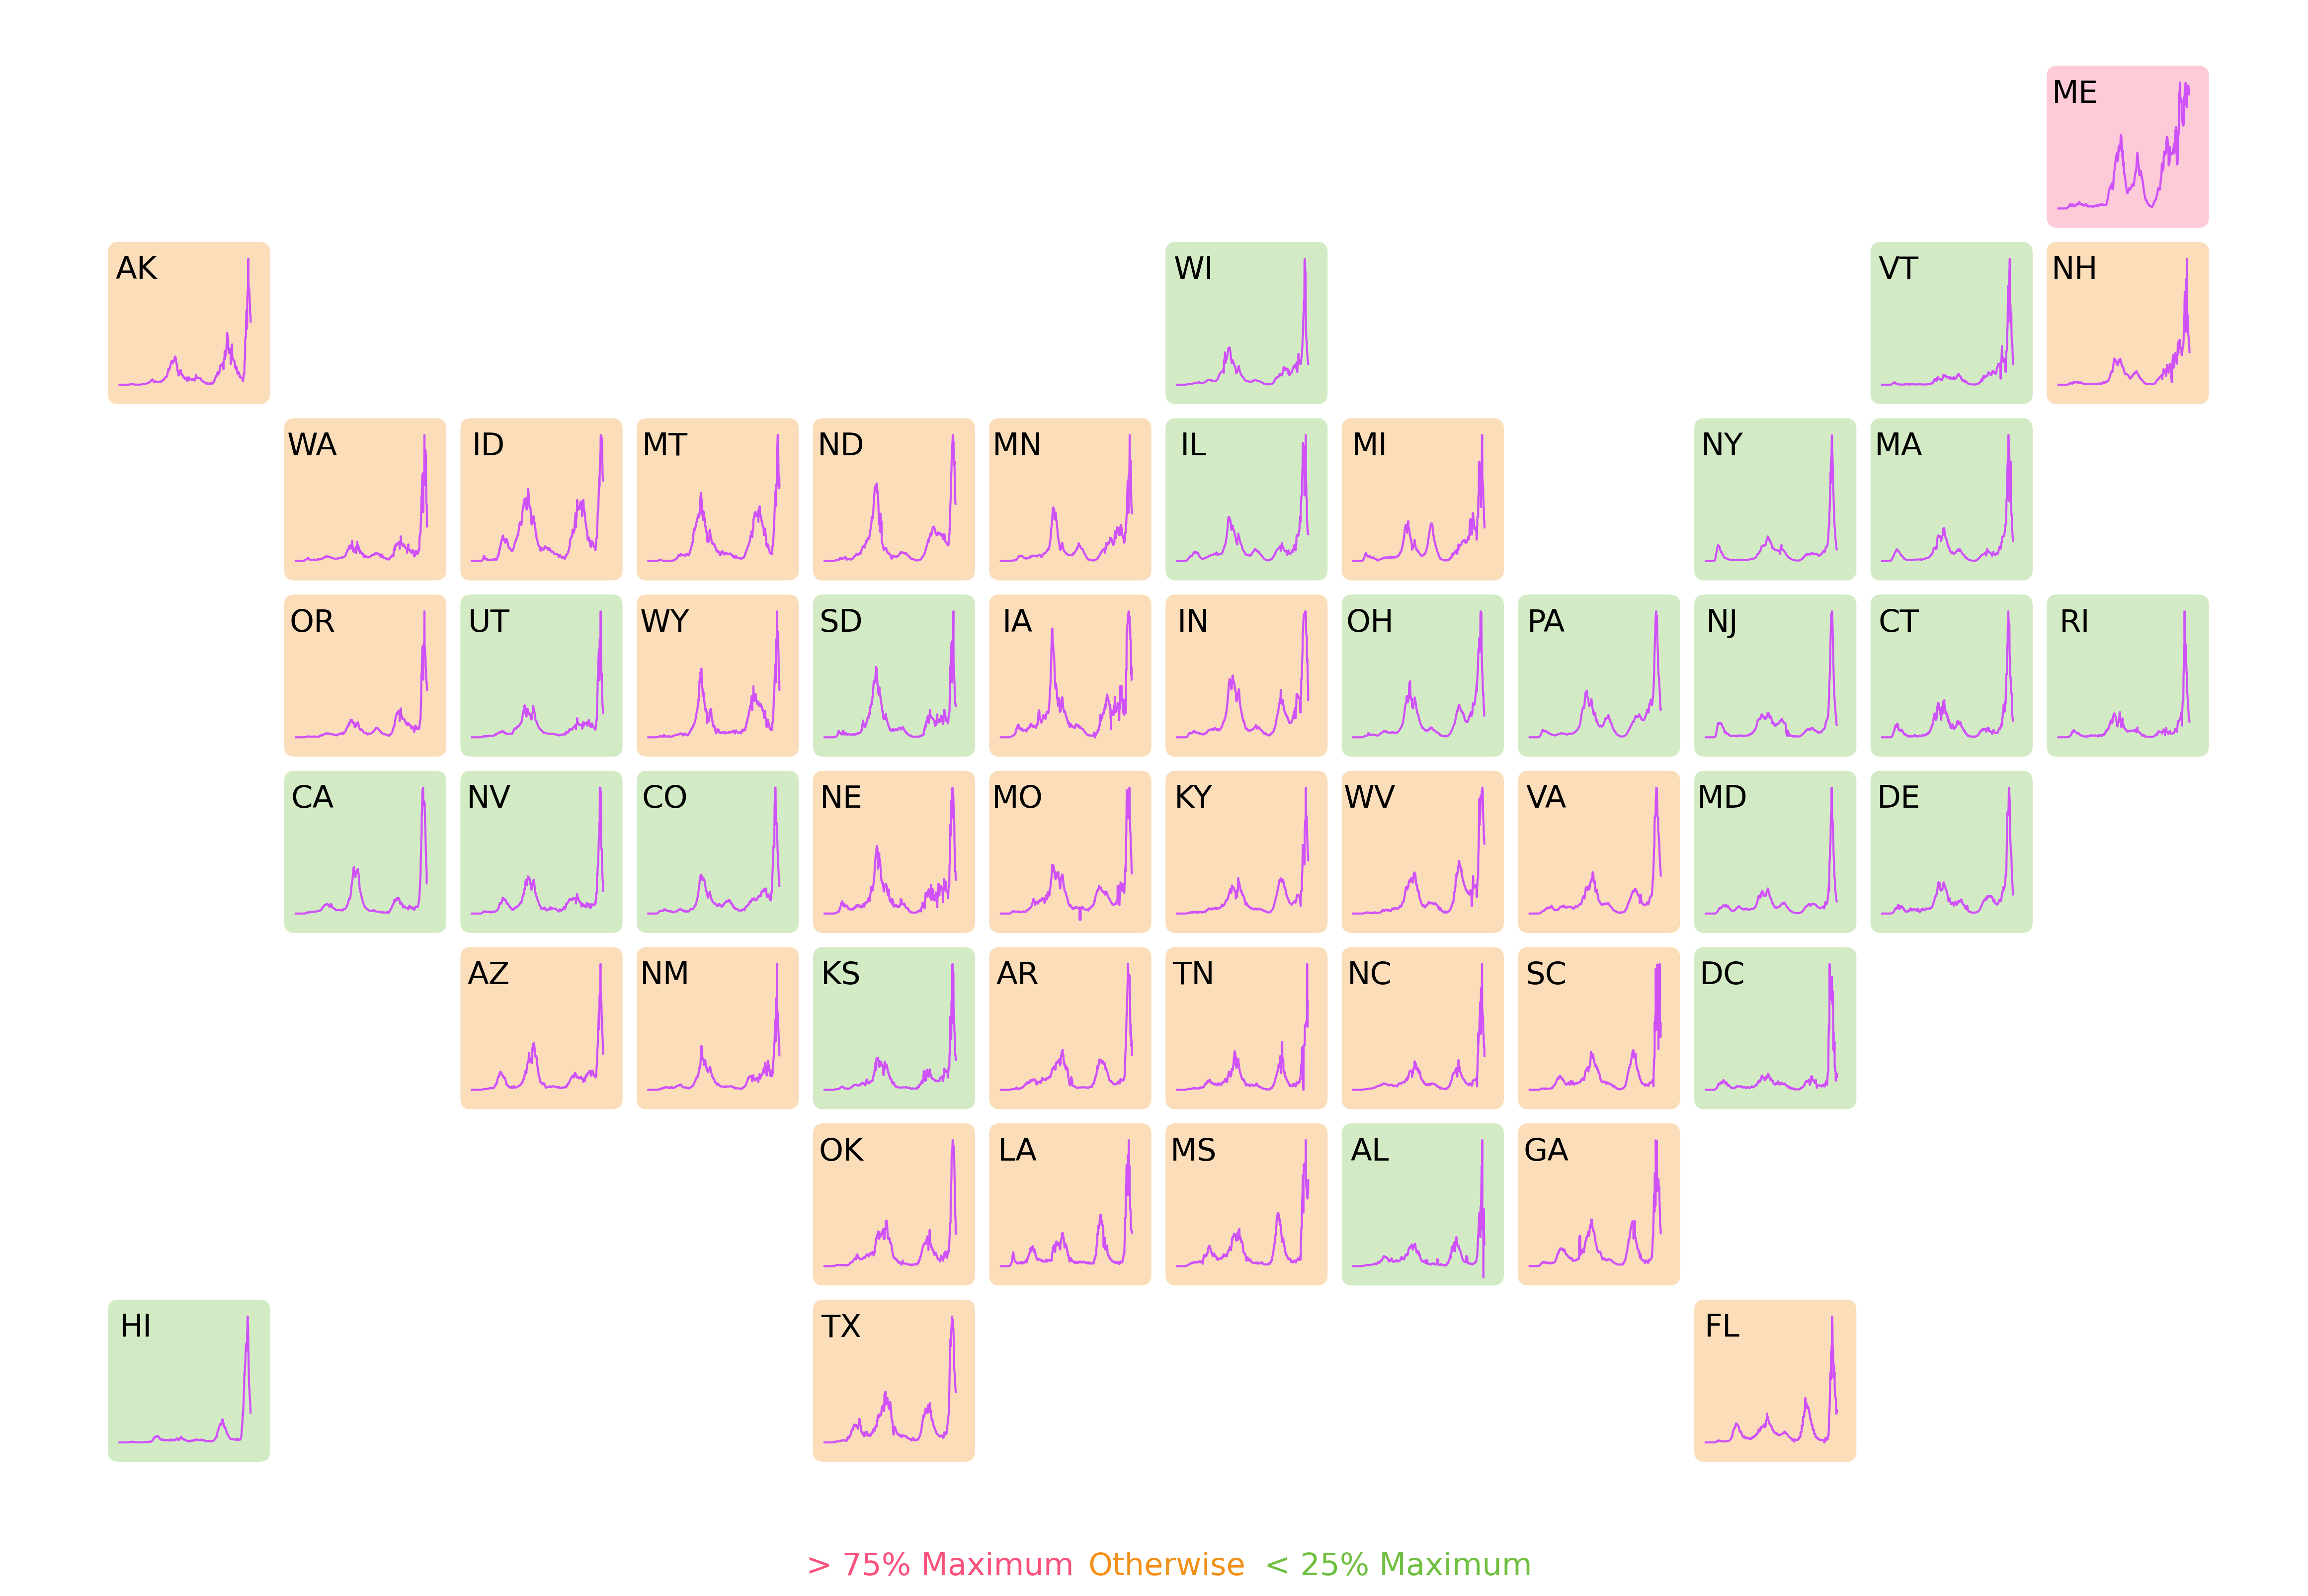

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []
color_list = []

x = np.linspace(0., 0.75, confirmed_US.shape[0])

for state in states.index:
    daily = confirmed_US[state_dict[state]].diff(1).rolling(7).mean()
    
    timeline = (daily/daily.max()).fillna(0).values
    color = colors[3]
    
    if timeline[-1] > 0.75:
        color = colors[5]
    elif timeline[-1] < 0.25:
        color = colors[2]
    
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, states.y[state]-0.5], 0.8, 0.8,
                                        boxstyle=mpatches.BoxStyle("Round", pad=0.06))
    patches.append(fancybox)
    color_list.append(color)
    
    ax.text(y=states.y[state]-0.4, x=states.x[state]-0.4, 
            s=state, horizontalalignment='center', verticalalignment='center', fontsize=15)
    ax.plot(states.x[state]+x-0.5, states.y[state]-timeline/1.4+0.25, lw=1, color=colors[1])

collection = PatchCollection(patches, facecolors=color_list, alpha=0.3)
ax.add_collection(collection)

ax.text(x=3.4, y=8, s='> 75% Maximum', color=colors[5], fontsize=15, ha='left')
ax.text(x=5, y=8, s='Otherwise',     color=colors[3], fontsize=15, ha='left')
ax.text(x=6, y=8, s='< 25% Maximum', color=colors[2], fontsize=15, ha='left')

ax.axis('off')
fig.patch.set_facecolor('#FFFFFF')
fig.tight_layout()

### Norway vs Sweden

We can also easily compare two similar countries to determine the effect of different approaches. The "classic" example is to compare Norway and Sweden as they are extremely similar countries geographically and culturally (Norway became independent from Sweden in 1915) but Sweden decided to no impose a official lock down, while Norway went on lockdown starting on the evening on March 12.

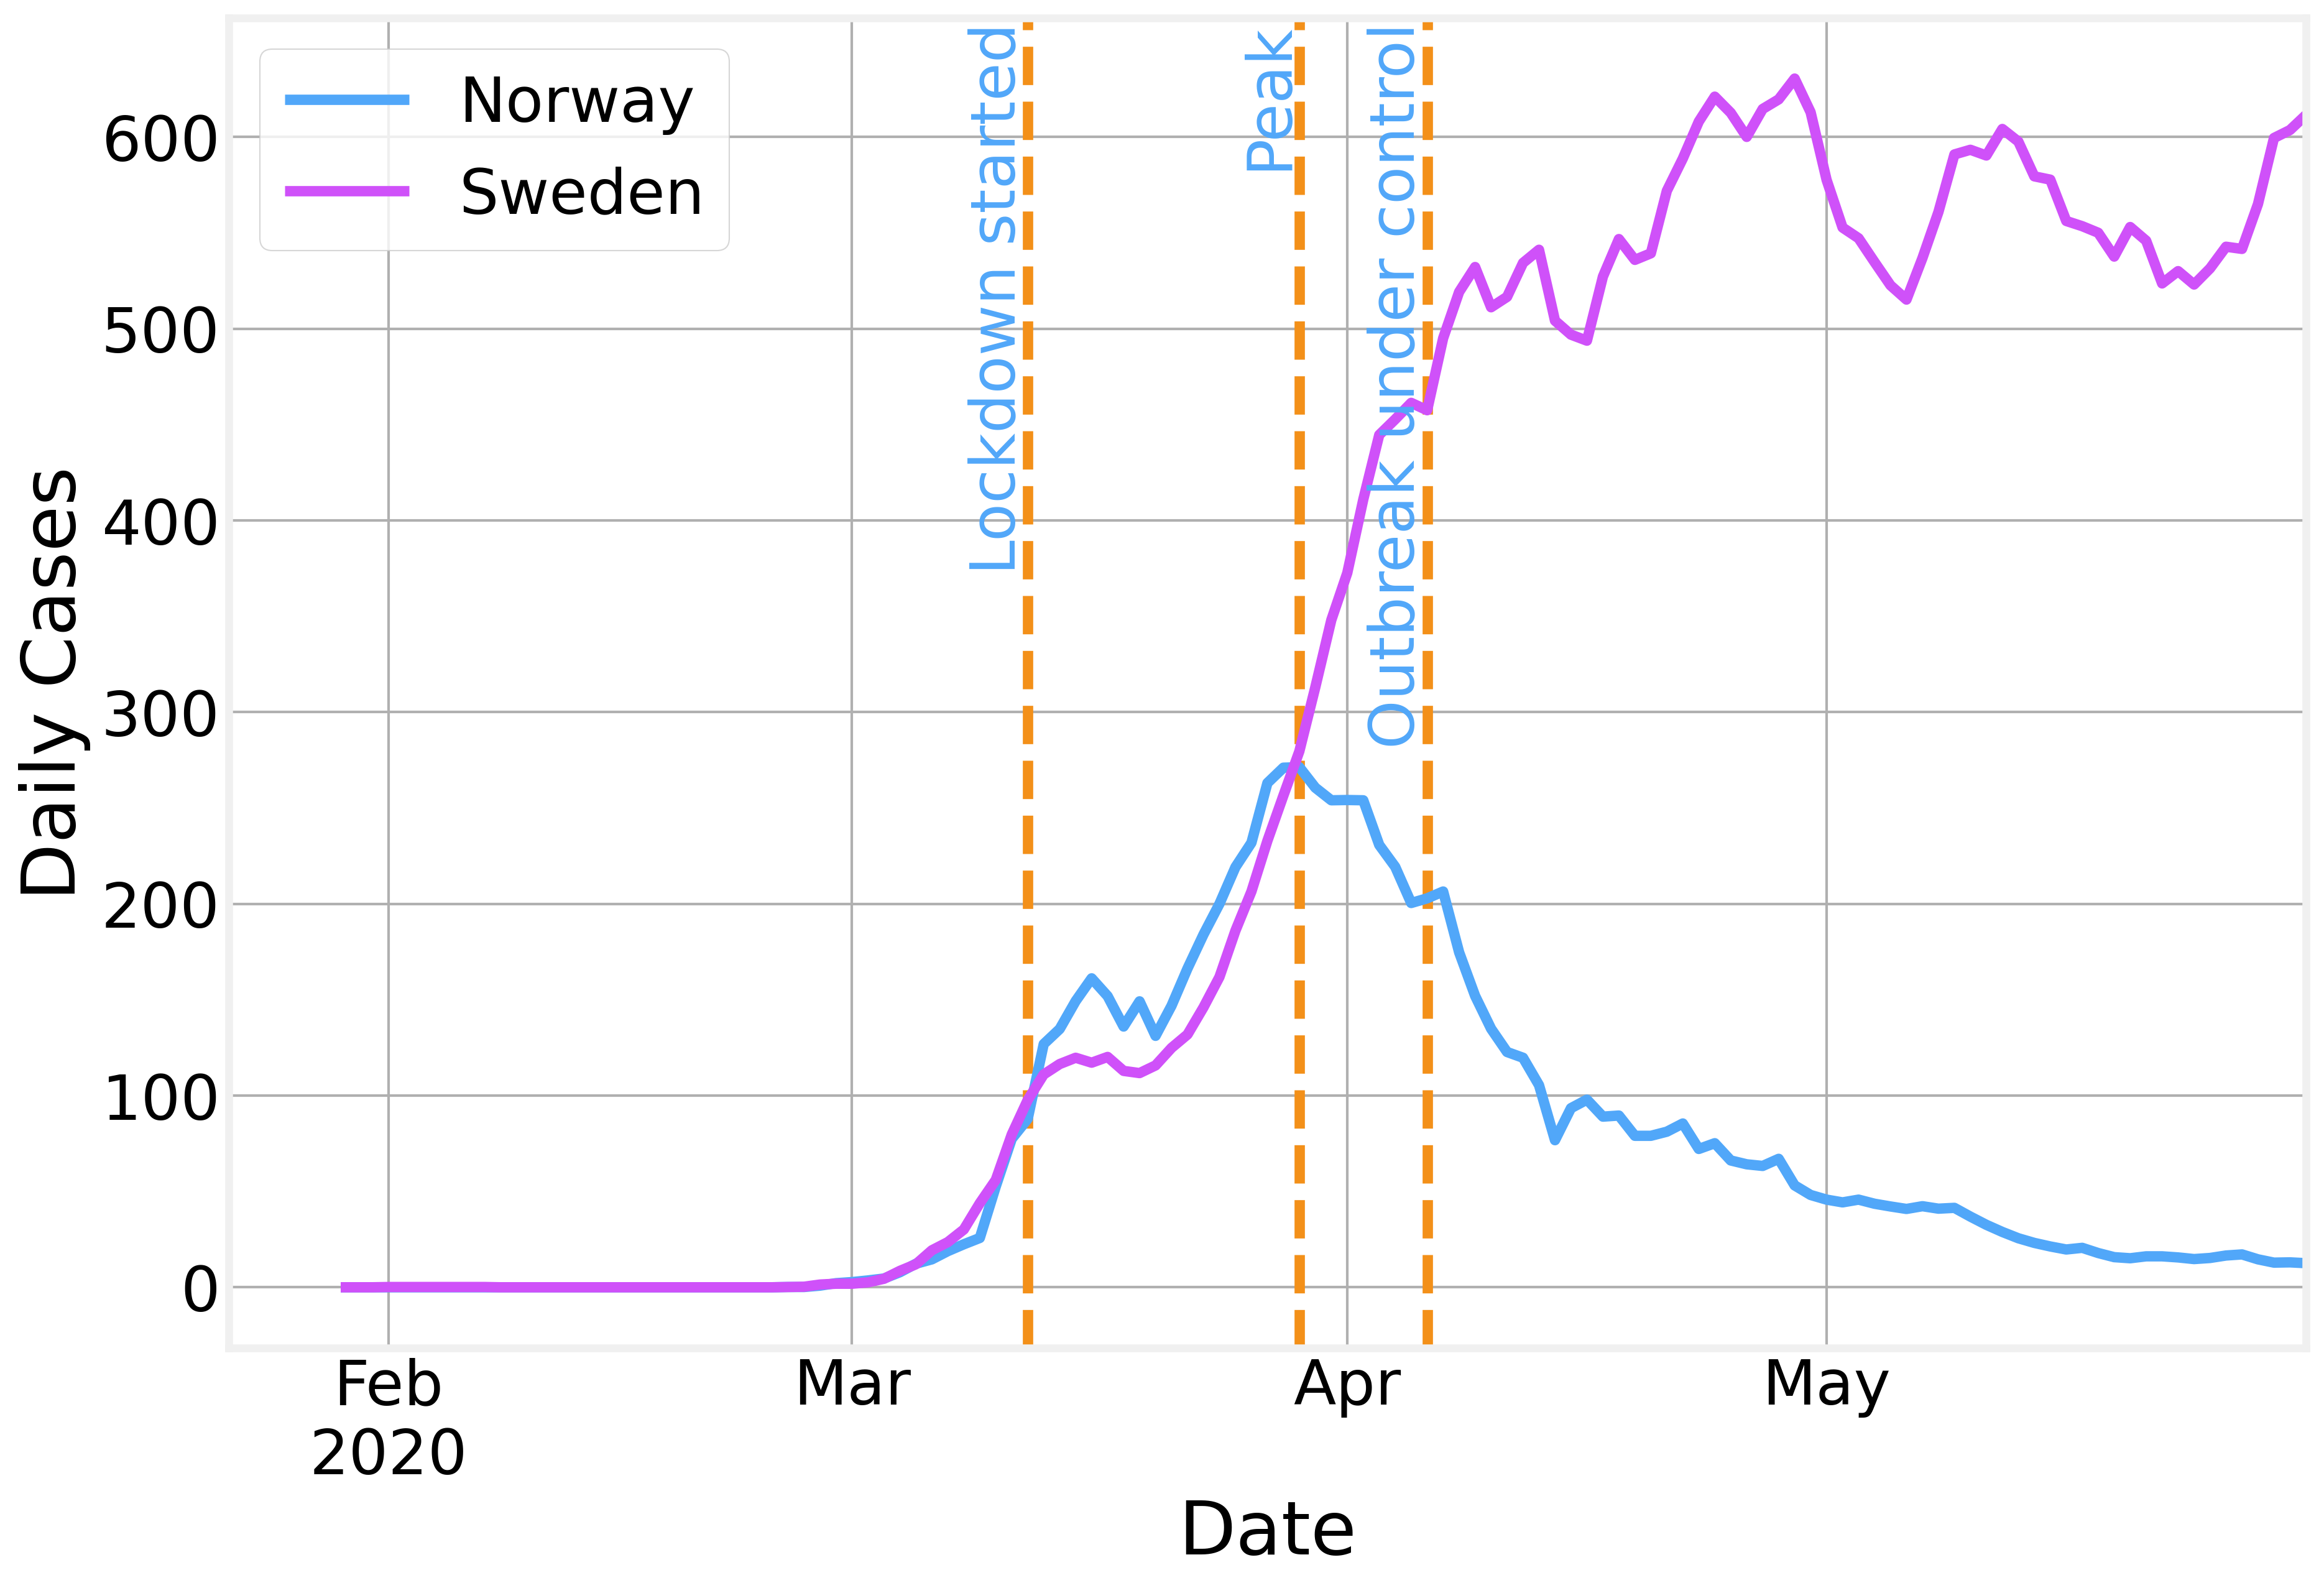

In [35]:
ax = confirmed_timeline[['Norway', 'Sweden']].diff(1).rolling(7).mean()[:'2020-05'].plot()
ymin, ymax = ax.get_ylim()
ax.vlines(x=['2020/03/12', '2020/03/29', '2020/04/06'], ymin=ymin, ymax=ymax, linestyles='--', colors=colors[3])
ax.text(x='2020/03/12', y=ymax-2, s='Lockdown started', rotation=90, ha='right', va='top', color=colors[0])
ax.text(x='2020/03/29', y=ymax-2, s='Peak', rotation=90, ha='right', va='top', color=colors[0])
ax.text(x='2020/04/06', y=ymax-2, s='Outbreak under control', rotation=90, ha='right', va='top', color=colors[0])
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Cases')
ax.legend()

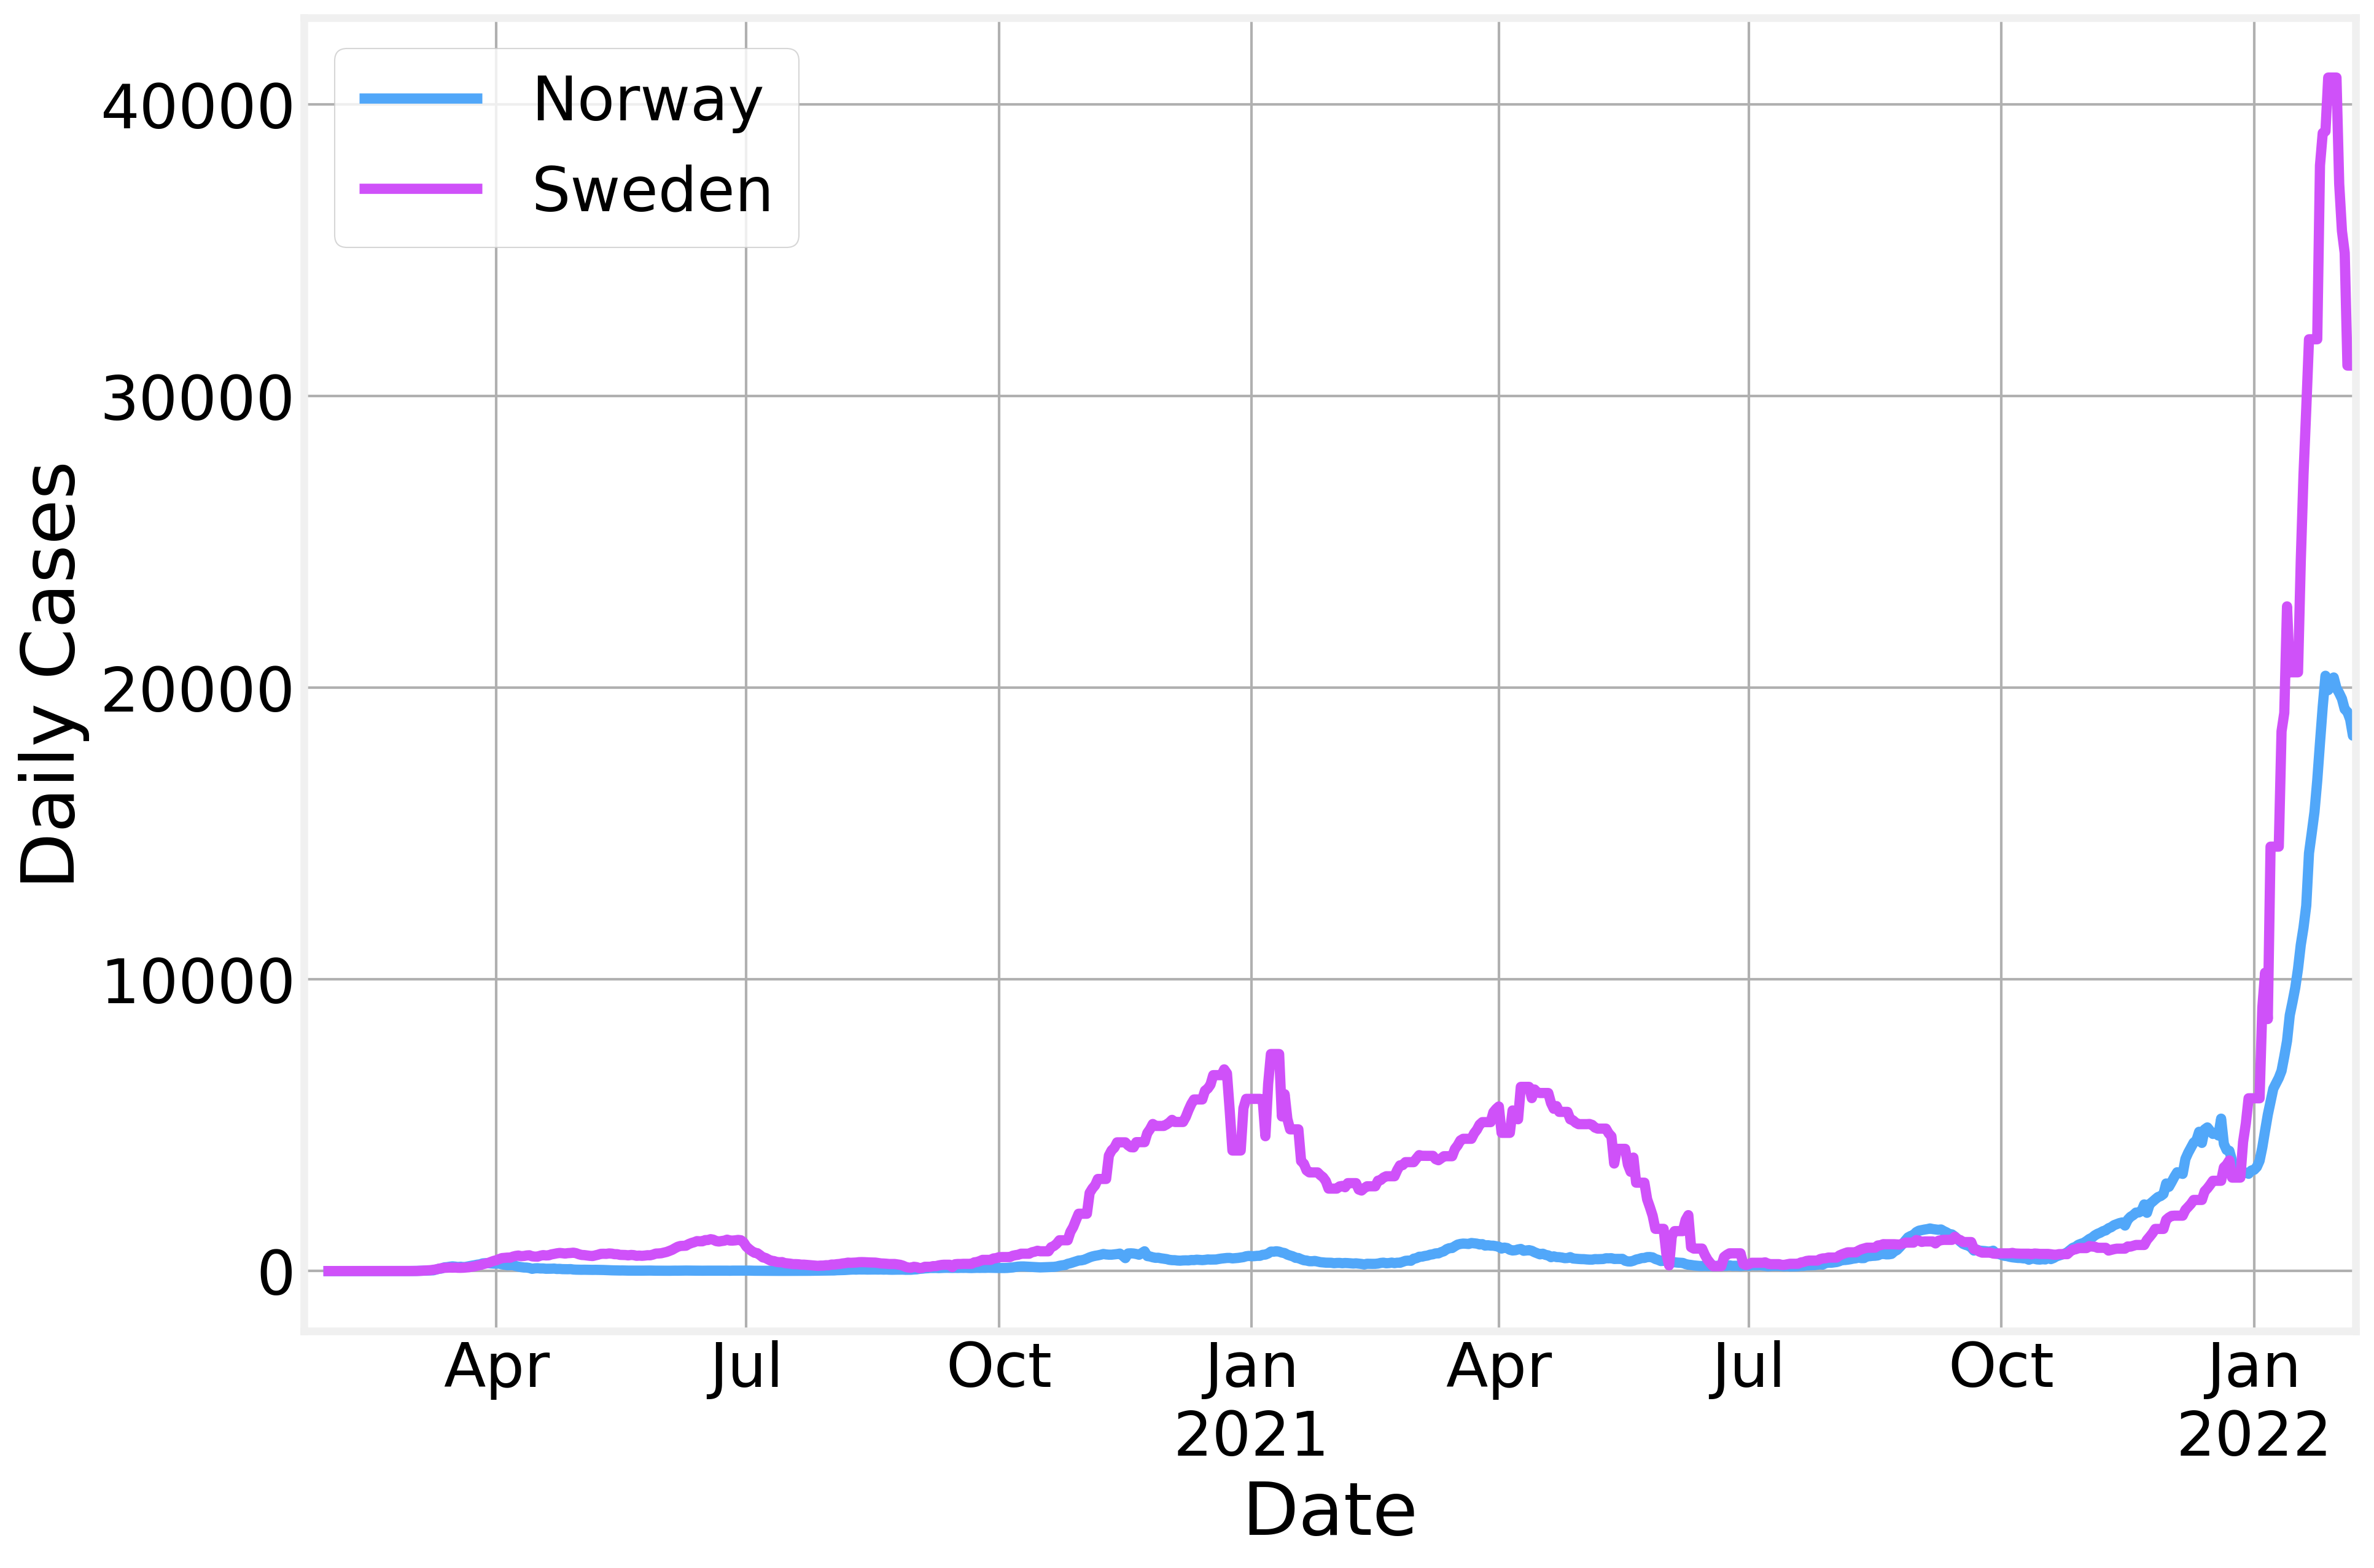

In [36]:
ax = confirmed_timeline[['Norway', 'Sweden']].diff(1).rolling(7).mean().plot()
ymin, ymax = ax.get_ylim()
ax.set_xlabel('Date')
ax.set_ylabel('Daily Cases')
ax.legend()

Similarly, for the number of deaths

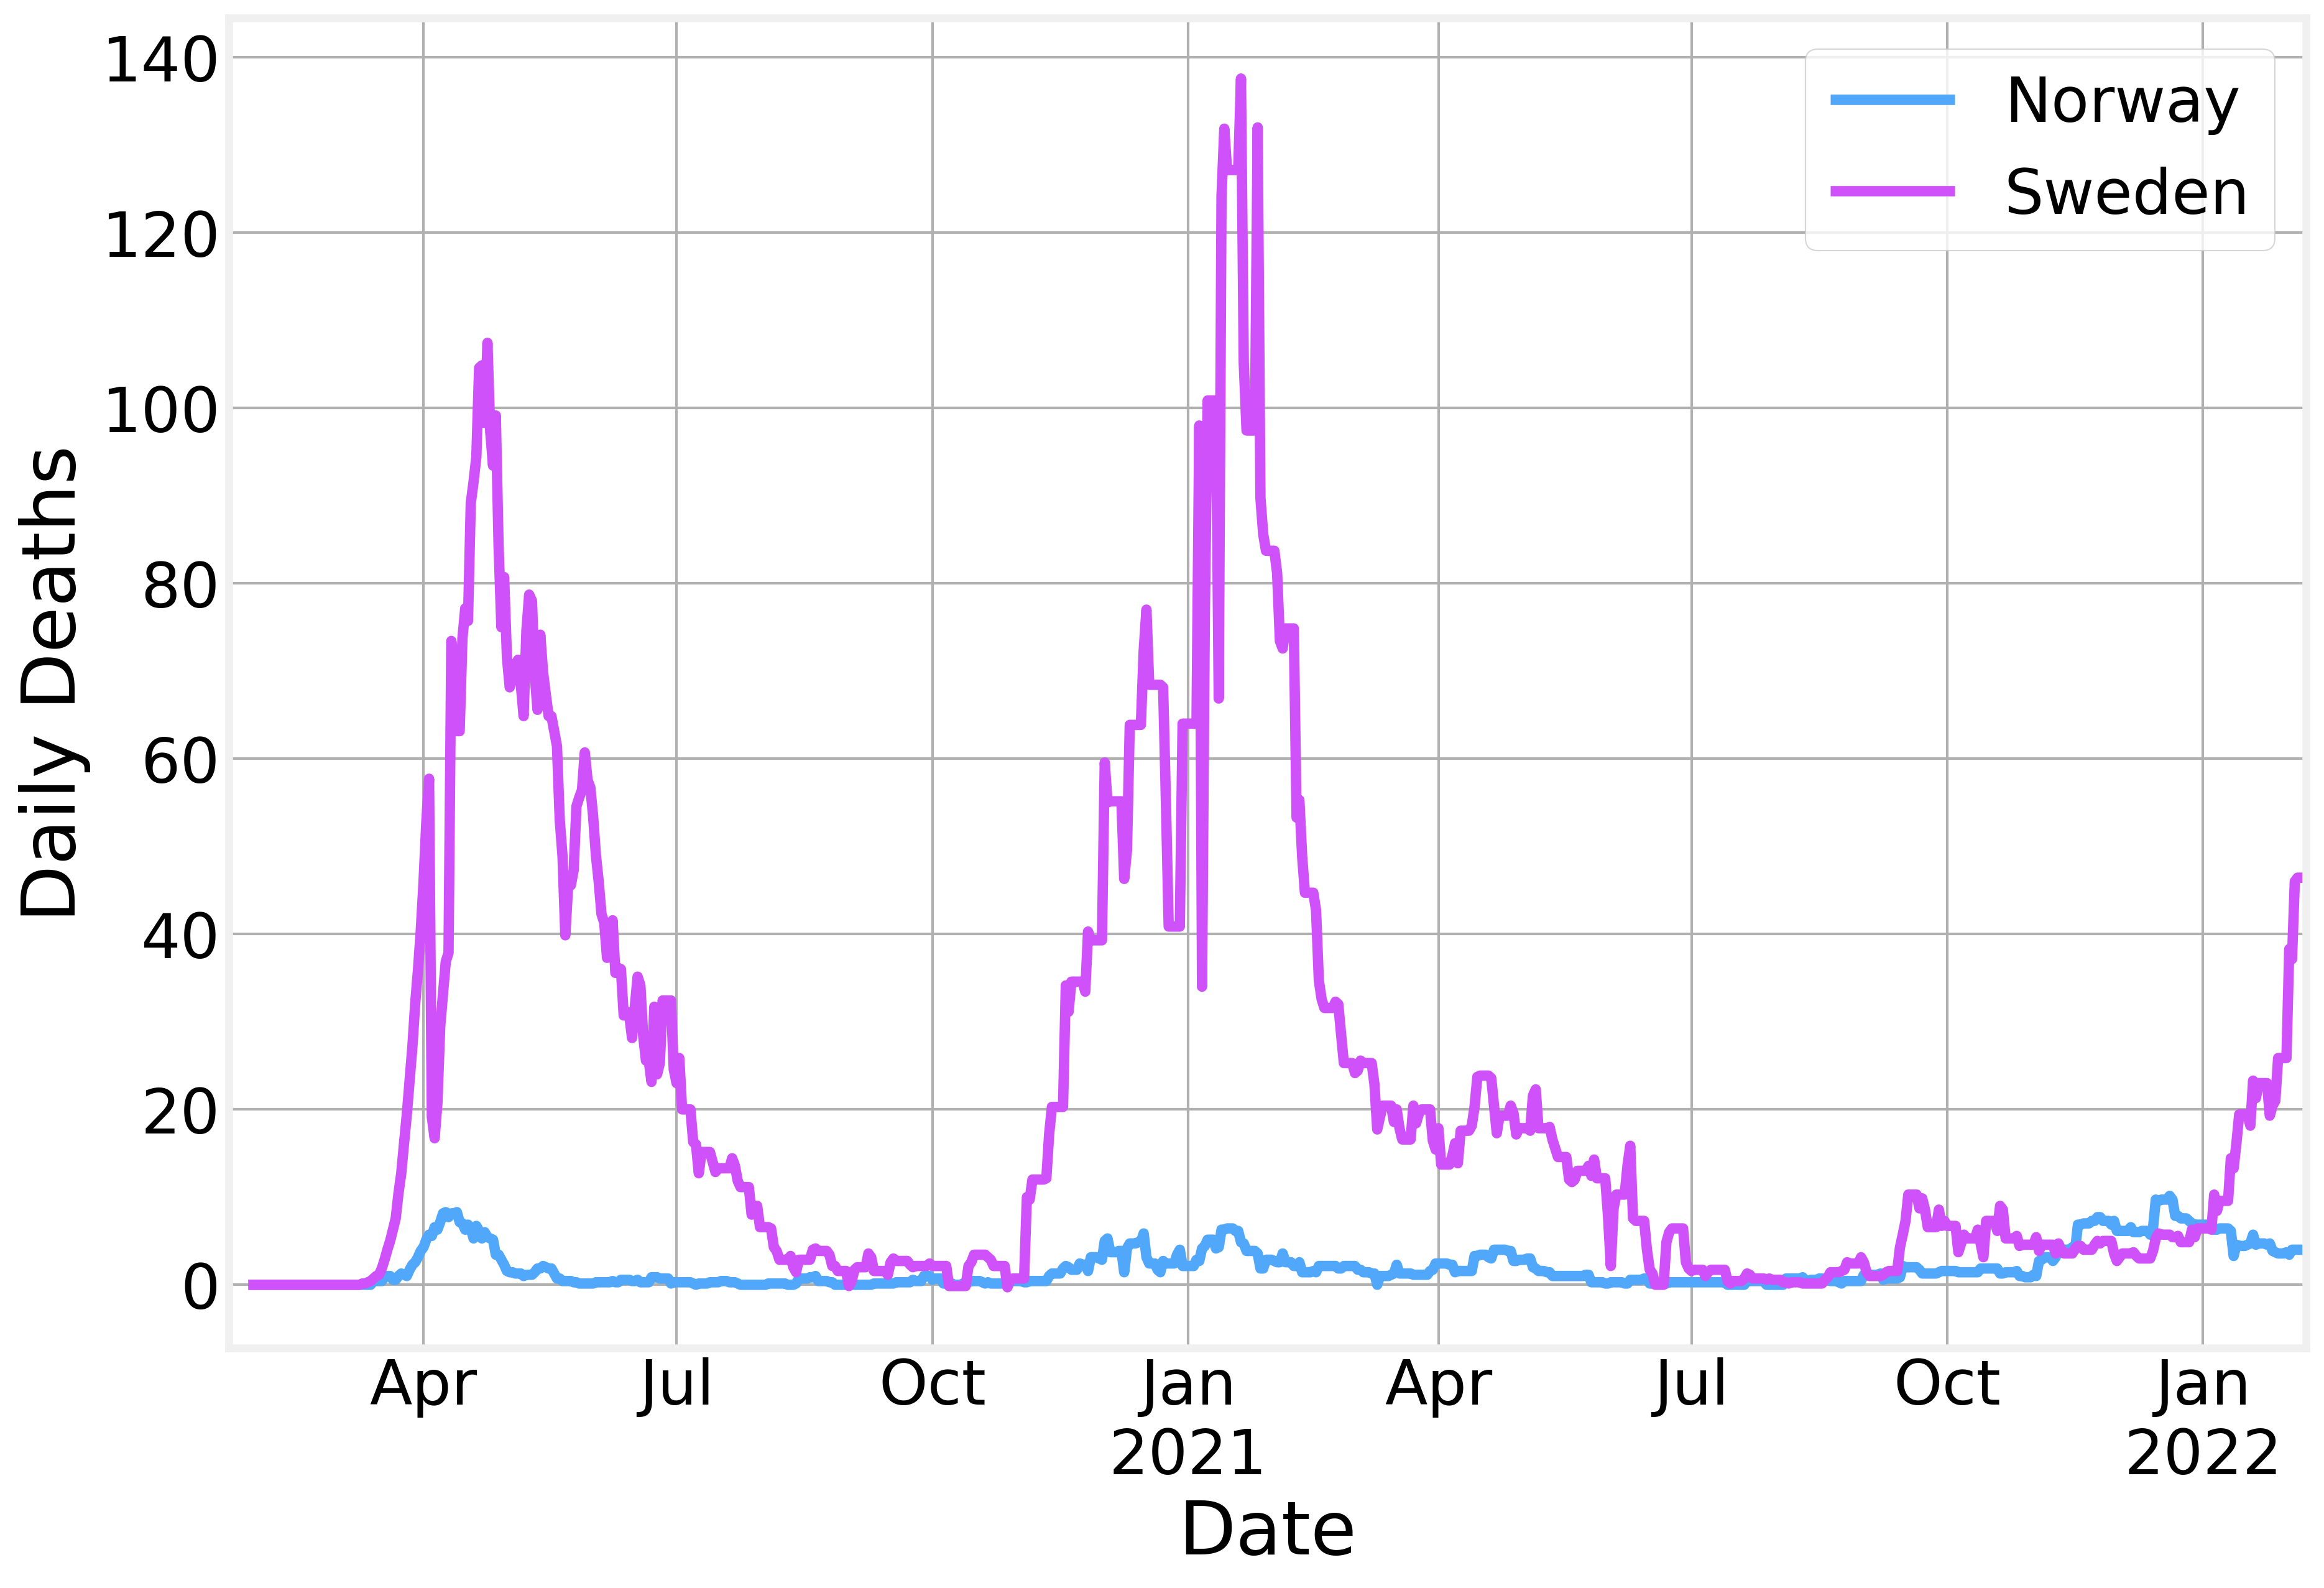

In [37]:
ax = deaths_timeline[['Norway', 'Sweden']].diff(1).rolling(7).mean().plot()
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')
ax.legend()

<div style="width: 100%; overflow: hidden; float: center;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>